# Telco Customer Churn Prediction with AutoGluon

이 노트북은 AutoGluon을 사용하여 통신사 고객 이탈을 예측하는 모델을 만듭니다.

**순서**
1. 컬럼별로 데이터 분석 및 시각화
2. 전처리
3. 특성 엔지니어링
4. 모델링
5. 앙상블
6. 모델 비교 평가
7. submission.csv 파일 생성


| 분류 | 고객 인구통계 및 결제 (Demographics & Billing) | 분류 | 서비스 가입 정보 (Services & Contract) |
| :--- | :--- | :--- | :--- |
| **customerID** | 고객 식별 번호 (ID) | **tenure** | 고객의 가입 기간 (개월 수) |
| **gender** | 성별 (Female, Male) | **PhoneService** | 전화 서비스 사용 여부 |
| **SeniorCitizen** | 고령자 여부 (0:젊은층, 1:고령자) | **MultipleLines** | 다중 회선 사용 여부 |
| **Partner** | 배우자 유무 (Yes, No) | **InternetService** | 인터넷 서비스 제공업체 종류 |
| **Dependents** | 부양가족 유무 (Yes, No) | **OnlineSecurity** | 온라인 보안 서비스 유무 |
| **PaperlessBilling** | 전자청구서 사용 여부 (Yes, No) | **OnlineBackup** | 온라인 백업 서비스 유무 |
| **PaymentMethod** | 결제 방법 (카드, 이체, 수표 등) | **DeviceProtection** | 기기 보호 서비스 유무 |
| **MonthlyCharges** | 월간 요금 (Monthly) | **TechSupport** | 기술 지원 서비스 유무 |
| **TotalCharges** | 총 누적 요금 (수치형 변환 필요) | **StreamingTV** | 스트리밍 TV 이용 유무 |
| **Churn** | **고객 이탈 여부 (Target: Yes/No)** | **StreamingMovies** | 스트리밍 영화 이용 유무 |
| **Contract** | **계약 기간 (1개월/1년/2년)** | | |

In [11]:
# 1. 라이브러리 임포트 및 데이터 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import math
import os

# 시각화 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. 파일 존재 여부 먼저 확인
file_path = 'data/Telco-Customer-Churn.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("✅ 데이터 로드 성공!")
    
    # 2. 'df'가 판다스 데이터프레임인지 확인
    if isinstance(df, pd.DataFrame):
        print("✅ df 변수가 데이터프레임으로 정상 선언되었습니다.")
        display(df.head())  # 이제 에러 없이 작동할 것입니다.
    else:
        print("❌ 변수 df가 데이터프레임이 아닙니다.")
else:
    print(f"❌ 에러: {file_path} 경로에 파일이 없습니다. 경로를 확인해주세요!")

✅ 데이터 로드 성공!
✅ df 변수가 데이터프레임으로 정상 선언되었습니다.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [13]:
import warnings

# 모든 경고 메시지 무시하기
warnings.filterwarnings(action='ignore')

In [14]:
# 데이터 전처리 전, TotalCharges의 빈 문자열 처리 필요
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# 2. 컬럼별 데이터 분석 및 시각화 (EDA)
데이터의 분포와 이탈률(Churn)과의 관계를 살펴봅니다.

In [15]:
# Churn을 수치형으로 변환 (시각화를 위해)
df['Churn_Numeric'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [16]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Text(0.5, 1.0, '이탈고객수')

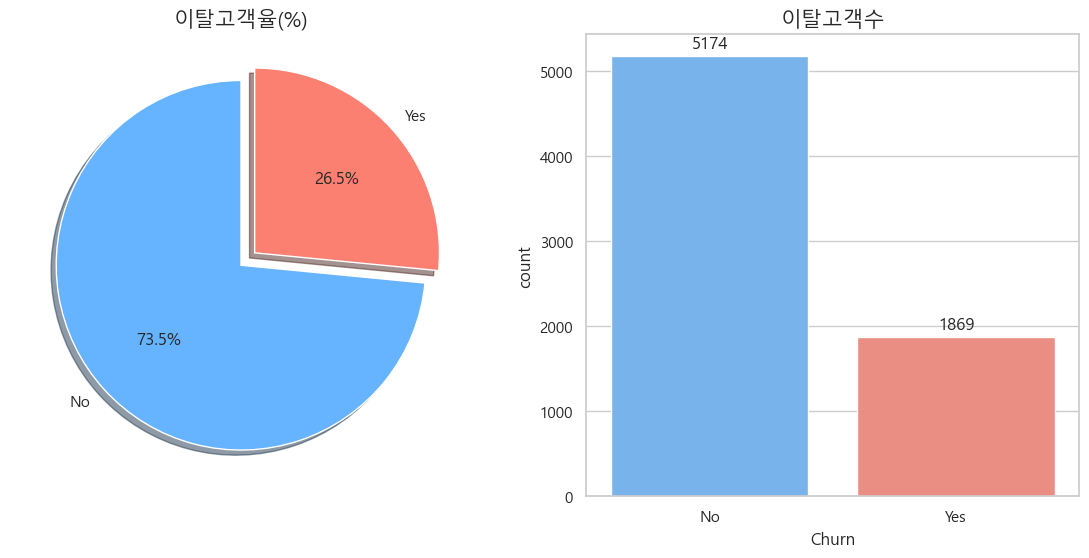

In [17]:
# 1. 데이터 준비
churn_counts = df['Churn'].value_counts()
labels = churn_counts.index # ['No', 'Yes']

# 2. 그래프 영역 설정 (1행 2열)
plt.figure(figsize=(14, 6))

# --- 좌측: 파이 차트 (비율 확인) ---
plt.subplot(1, 2, 1)
plt.pie(churn_counts, labels=labels, autopct='%.1f%%', startangle=90, 
        explode=[0, 0.1], colors=['#66b3ff','#fb8072'], shadow=True)
plt.title('이탈고객율(%)', fontsize=15)

# --- 우측: 카운트 플롯 (실제 인원수 확인) ---
plt.subplot(1, 2, 2)
ax = sns.countplot(
    x='Churn', 
    data=df, 
    hue='Churn',              # x와 동일한 변수를 hue에 할당
    palette=['#66b3ff','#fb8072'], 
    legend=False              # 중복되는 범례 제거
)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3) # 실제 명수 표시

plt.title('이탈고객수', fontsize=15)


### 전체 데이터의 26.5%가 이탈하고 있음

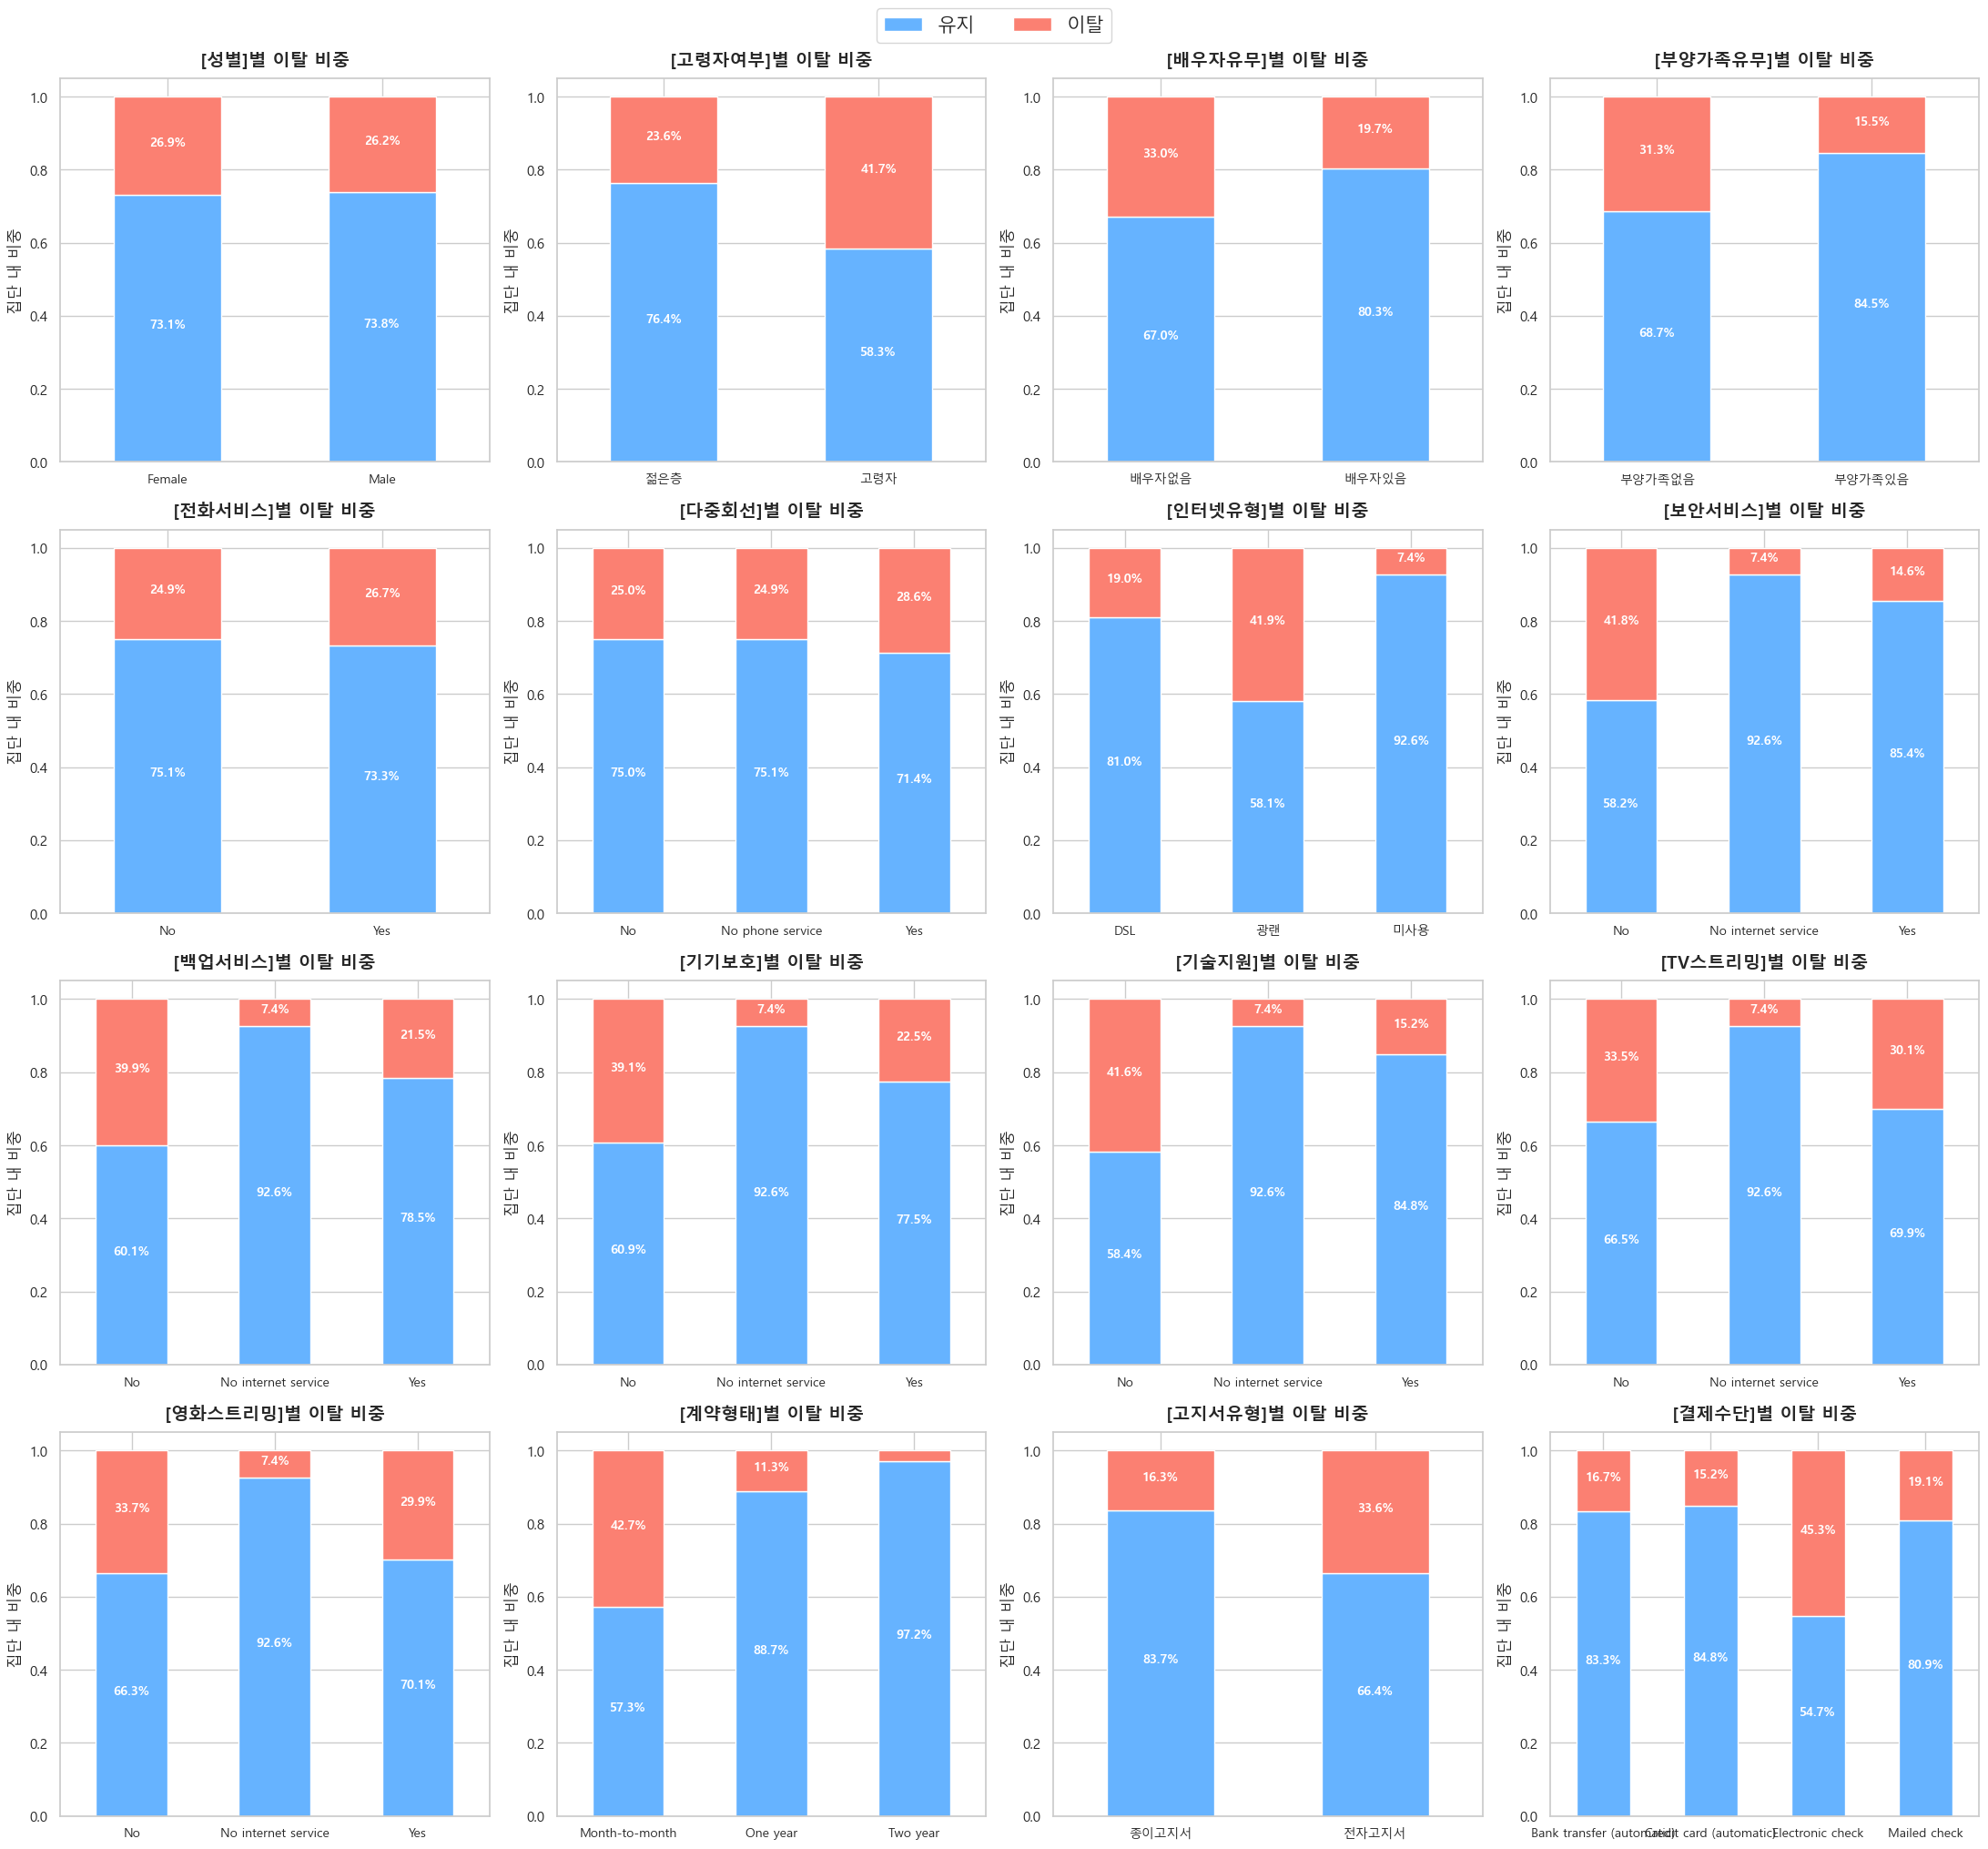

In [18]:
# --- 분석 대상 컬럼 및 한글 매핑 딕셔너리 ---
target_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
               'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
               'Contract', 'PaperlessBilling', 'PaymentMethod']

column_kor = {
    'gender': '성별', 'SeniorCitizen': '고령자여부', 'Partner': '배우자유무',
    'Dependents': '부양가족유무', 'PhoneService': '전화서비스', 'MultipleLines': '다중회선',
    'InternetService': '인터넷유형', 'OnlineSecurity': '보안서비스', 'OnlineBackup': '백업서비스',
    'DeviceProtection': '기기보호', 'TechSupport': '기술지원', 'StreamingTV': 'TV스트리밍',
    'StreamingMovies': '영화스트리밍', 'Contract': '계약형태', 'PaperlessBilling': '고지서유형',
    'PaymentMethod': '결제수단'
}

# x축 항목값을 직관적으로 바꾸기 위한 매핑
label_map = {
    'SeniorCitizen': {0: '젊은층', 1: '고령자'},
    'PaperlessBilling': {'Yes': '전자고지서', 'No': '종이고지서'},
    'Partner': {'Yes': '배우자있음', 'No': '배우자없음'},
    'Dependents': {'Yes': '부양가족있음', 'No': '부양가족없음'},
    'InternetService': {'Fiber optic': '광랜', 'DSL': 'DSL', 'No': '미사용'}
}

# --- 격자 설정 (4열 구성) ---
n_cols = 4
n_rows = math.ceil(len(target_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(target_cols):
    # 데이터 집계 및 비율 변환
    cross_tab = pd.crosstab(df[col], df['Churn'])
    cross_tab_prop = cross_tab.div(cross_tab.sum(1).astype(float), axis=0)
    
    # 그래프 그리기
    cross_tab_prop.plot(kind='bar', stacked=True, ax=axes[i], 
                        color=['#66b3ff','#fb8072'], legend=False)
    
    # x축 라벨을 한국어로 변경
    current_labels = [tick.get_text() for tick in axes[i].get_xticklabels()]
    # SeniorCitizen처럼 숫자인 경우 형변환 대응
    new_labels = []
    for label in current_labels:
        # 숫자로 된 문자열일 경우 실제 숫자로 변환하여 매핑 시도
        clean_label = int(label) if label.isdigit() else label
        new_labels.append(label_map.get(col, {}).get(clean_label, label))
    
    axes[i].set_xticklabels(new_labels, rotation=0, fontsize=10)

    # 비율 표시 (%)
    for n, x_idx in enumerate([*cross_tab_prop.index.values]):
        cumulative_y = 0
        for proportion in cross_tab_prop.loc[x_idx]:
            if proportion > 0.05:
                axes[i].text(x=n, y=cumulative_y + (proportion / 2),
                             s=f'{proportion*100:.1f}%', 
                             color="white", fontsize=10, fontweight="bold", ha="center")
            cumulative_y += proportion

    kor_title = column_kor.get(col, col)
    axes[i].set_title(f'[{kor_title}]별 이탈 비중', fontsize=14, fontweight='bold', pad=10)
    axes[i].set_ylabel('집단 내 비중')
    axes[i].set_xlabel('')

# 범례 및 여백 정리
fig.legend(['유지', '이탈'], loc='upper center', ncol=2, fontsize=15, bbox_to_anchor=(0.5, 1.02))

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 유의미한 변수
1. 가입기간
2. 결제 수단
3. 인터넷 서비스 유형
4. 연령
5. 가족 형태: 배우자 유무, 부양가족 유무



# ① 가입기간 

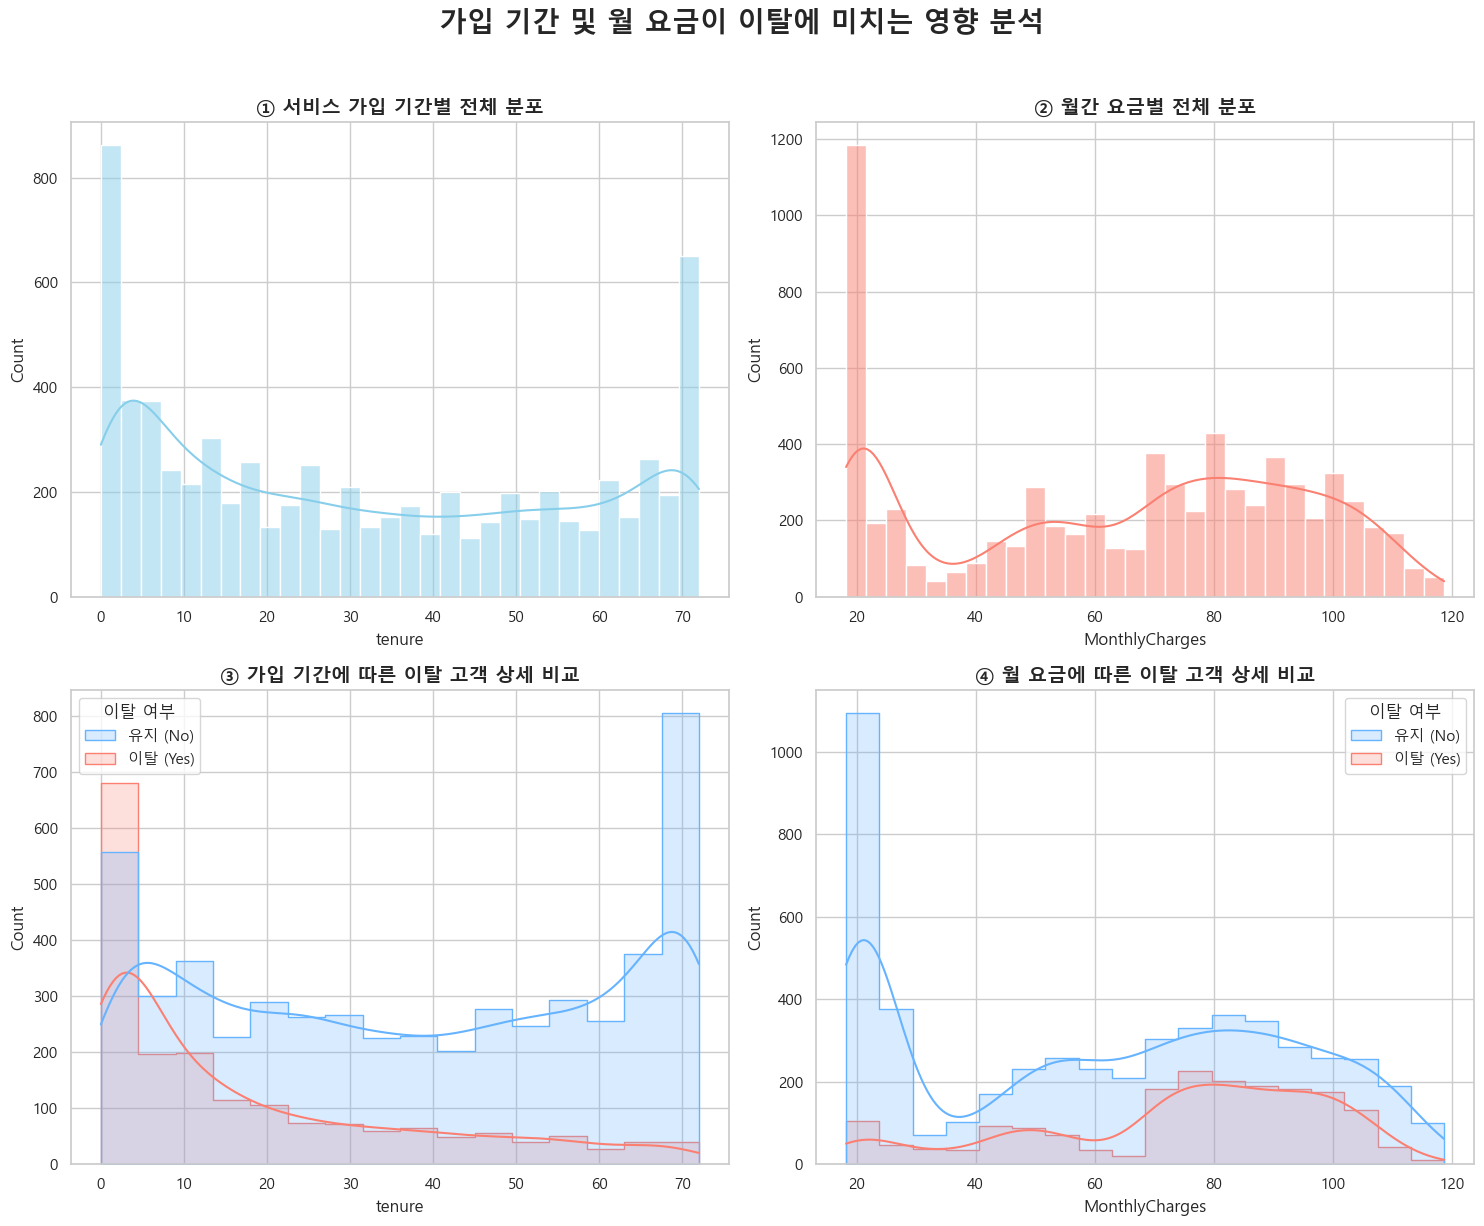

In [19]:
# 2x2 캔버스 생성
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# --- [1행 왼쪽/오른쪽] 전체 분포 (생략 없이 유지) ---
sns.histplot(df['tenure'], bins=30, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('① 서비스 가입 기간별 전체 분포', fontsize=14, fontweight='bold')
sns.histplot(df['MonthlyCharges'], bins=30, kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('② 월간 요금별 전체 분포', fontsize=14, fontweight='bold')

# --- [2행 핵심: 이탈 여부 비교] ---

# 3번 그래프 (가입 기간)
sns.histplot(data=df, x='tenure', hue='Churn', hue_order=['No', 'Yes'], 
             kde=True, element="step", palette=['#66b3ff', '#fb8072'], ax=axes[1, 0])
axes[1, 0].set_title('③ 가입 기간에 따른 이탈 고객 상세 비교', fontsize=14, fontweight='bold')
# 범례 강제 설정: 파란색(#66b3ff) = No(유지), 주황색(#fb8072) = Yes(이탈)
axes[1, 0].legend(handles=axes[1, 0].get_legend().legend_handles, 
                  labels=['유지 (No)', '이탈 (Yes)'], title='이탈 여부')

# 4번 그래프 (월 요금)
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', hue_order=['No', 'Yes'], 
             kde=True, element="step", palette=['#66b3ff', '#fb8072'], ax=axes[1, 1])
axes[1, 1].set_title('④ 월 요금에 따른 이탈 고객 상세 비교', fontsize=14, fontweight='bold')
# 범례 강제 설정: 파란색(#66b3ff) = No(유지), 주황색(#fb8072) = Yes(이탈)
axes[1, 1].legend(handles=axes[1, 1].get_legend().legend_handles, 
                  labels=['유지 (No)', '이탈 (Yes)'], title='이탈 여부')

# 전체 레이아웃 조정
plt.suptitle('가입 기간 및 월 요금이 이탈에 미치는 영향 분석', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

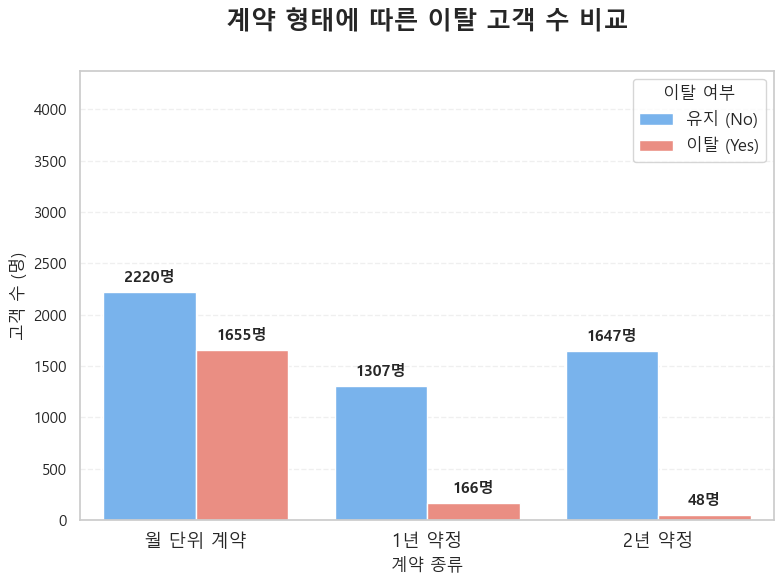

In [20]:
# 그래프 생성
plt.figure(figsize=(8, 6))

# 주황색(#fb8072) = 이탈(Yes), 파란색(#66b3ff) = 유지(No)
ax = sns.countplot(x='Contract', hue='Churn', data=df, 
                   palette=['#66b3ff', '#fb8072'], 
                   order=['Month-to-month', 'One year', 'Two year'],
                   hue_order=['No', 'Yes'])

# 막대 위에 인원 수 표시 (0명 제외 로직 추가)
for p in ax.patches:
    height = p.get_height()
    # height가 0보다 클 때만 텍스트를 작성하도록 조건 추가
    if height > 0:
        ax.annotate(f'{int(height)}명', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', fontweight='bold', fontsize=11)

plt.title('계약 형태에 따른 이탈 고객 수 비교', fontsize=18, fontweight='bold', pad=30)
plt.xticks([0, 1, 2], ['월 단위 계약', '1년 약정', '2년 약정'], fontsize=13)
plt.xlabel('계약 종류', fontsize=12)
plt.ylabel('고객 수 (명)', fontsize=12)

# 범례 설정 (순서 주의: 파랑-유지, 주황-이탈)
plt.legend(title='이탈 여부', labels=['유지 (No)', '이탈 (Yes)'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# y축 상단 여유 공간 확보 (숫자가 잘리지 않게)
plt.ylim(0, df['Contract'].value_counts().max() + 500)

plt.tight_layout()
plt.show()

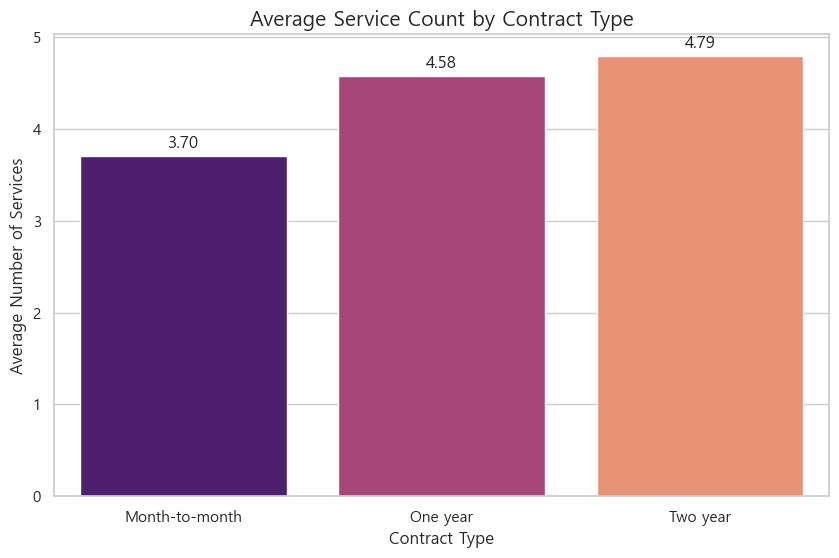

In [21]:
# 1. 서비스 관련 컬럼 리스트 (인터넷 서비스 자체와 부가 서비스들)
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# 2. 'Yes'인 경우를 1로 계산하여 합산 (InternetService는 'No'가 아니면 이용 중으로 간주할 수 있음)
df['ServiceCount'] = (df[service_cols] == 'Yes').sum(axis=1)
df['ServiceCount'] += (df['InternetService'] != 'No').astype(int)
# 3. 계약기간(Contract)별 서비스카운트(ServiceCount) 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Contract', 
    y='ServiceCount', 
    data=df, 
    hue='Contract',       # x축과 동일한 변수를 hue에 할당
    palette='magma', 
    errorbar=None,        # ci=None 대신 errorbar=None 사용
    legend=False          # 불필요한 범례 제거
)

# 막대 위에 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title('Average Service Count by Contract Type', fontsize=15)
plt.ylabel('Average Number of Services')
plt.xlabel('Contract Type')
plt.show()

* 신규가입자수가 많으나 월간 요금이 증가하는 경우 이를 유지 하지 못하고 이탈하는 수가 많아짐
* 써봤는데 별로네? 하고 나가는 경우일 것으로 추정.
* 해당 시기에 높은 초기 비용을 가질수록 이탈이 커진다. -> 비용 대비 가치가 낮다고 판단할 가능성이 있다.
* 신규 가입자의 이탈이 월 요금이 낮은 경우엔 적게 나타나는데, 신규 가입자 프로모션 등을 진행하여 월 요금을 낮춰 초기 이탈을 방지했을 것으로 추측됨.
* 월 단위 계약자 보다 2년 단위의 계약 고객의 서비스 이용 수가 높은데, 구독하는 서비스 종류가 많아질수록 장기 계약을 맺을 가능성이 크다고 판단된다.  -> 월단위 계약자가 많음

# ②결제수단

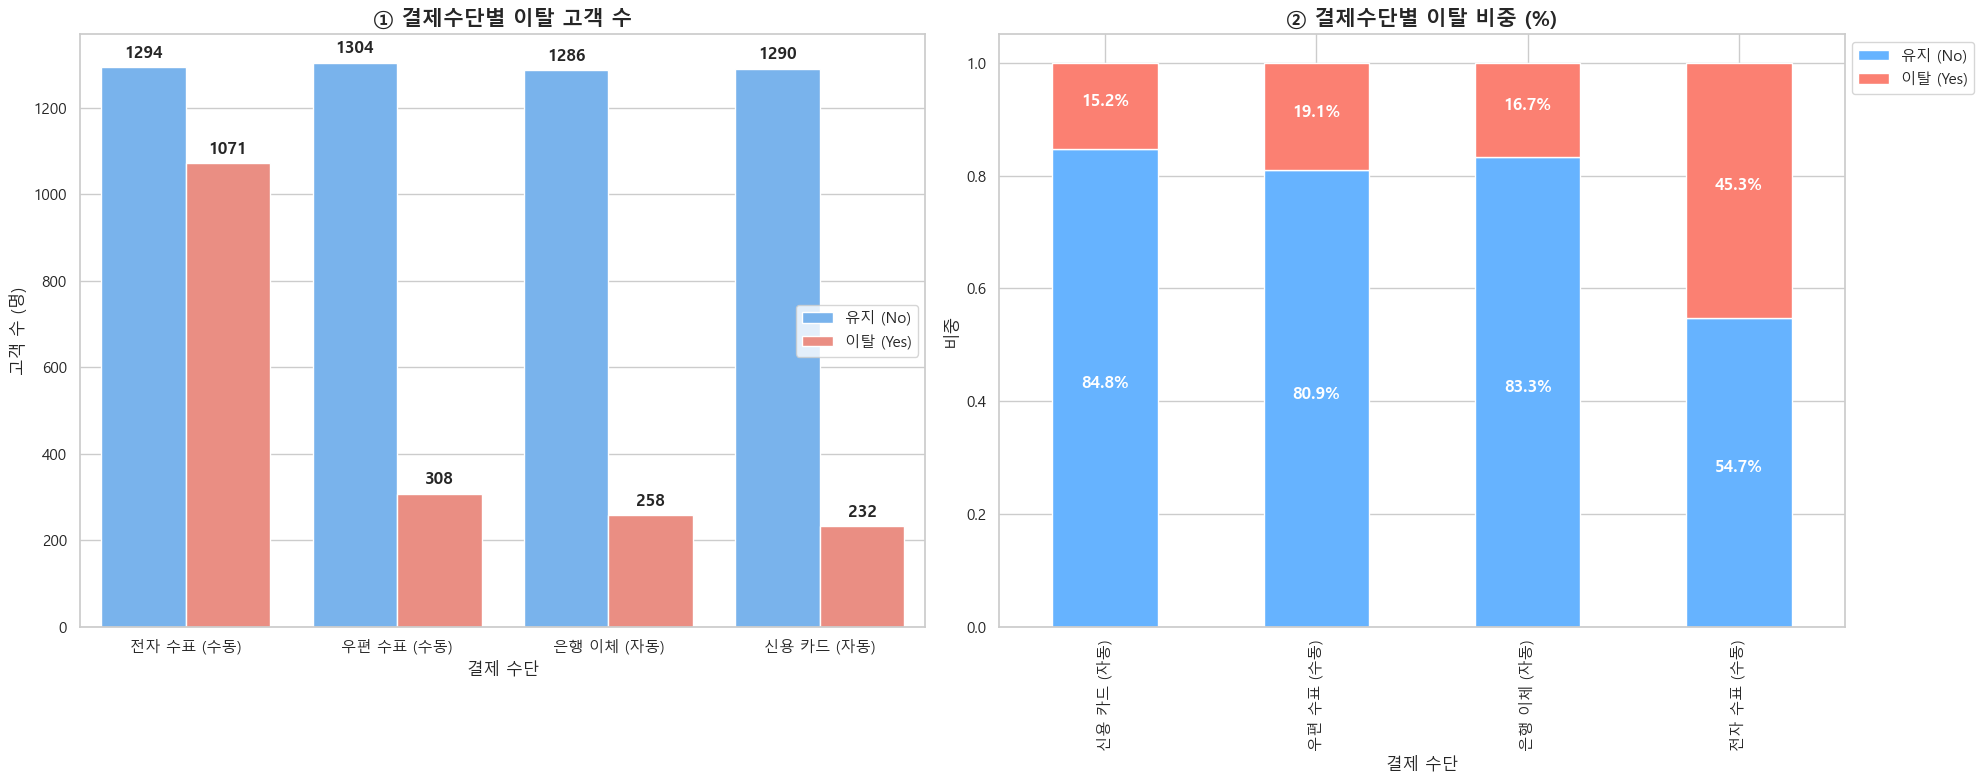

In [22]:
# 1. 결제수단 한글 매핑
payment_kor = {
    'Electronic check': '전자 수표 (수동)',
    'Mailed check': '우편 수표 (수동)',
    'Bank transfer (automatic)': '은행 이체 (자동)',
    'Credit card (automatic)': '신용 카드 (자동)'
}

# 2. 데이터 집계 및 가공
# 원본 데이터 훼손 방지를 위해 복사본 사용
df_temp = df.copy()
df_temp['PaymentMethod_Kor'] = df_temp['PaymentMethod'].map(payment_kor)

# 교차표 생성 및 비율 변환
pay_churn_tab = pd.crosstab(df_temp['PaymentMethod_Kor'], df_temp['Churn'])
pay_churn_prop = pay_churn_tab.div(pay_churn_tab.sum(1).astype(float), axis=0)

# 3. 시각화 (1행 2열 구성)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# [왼쪽] 결제수단별 고객 수 (Count)
sns.countplot(x='PaymentMethod_Kor', hue='Churn', data=df_temp, 
              palette=['#66b3ff', '#fb8072'], hue_order=['No', 'Yes'], ax=axes[0])
axes[0].set_title('① 결제수단별 이탈 고객 수', fontsize=15, fontweight='bold')
axes[0].set_xlabel('결제 수단')
axes[0].set_ylabel('고객 수 (명)')
axes[0].legend(['유지 (No)', '이탈 (Yes)'])

# 막대 위 숫자 표시
for p in axes[0].patches:
    height = p.get_height()
    if height > 0:
        axes[0].annotate(f'{int(height)}', (p.get_x() + p.get_width()/2., height),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

# [오른쪽] 결제수단별 이탈 비중 (Proportion)
pay_churn_prop.plot(kind='bar', stacked=True, color=['#66b3ff', '#fb8072'], ax=axes[1])
axes[1].set_title('② 결제수단별 이탈 비중 (%)', fontsize=15, fontweight='bold')
axes[1].set_xlabel('결제 수단')
axes[1].set_ylabel('비중')
axes[1].legend(['유지 (No)', '이탈 (Yes)'], loc='upper left', bbox_to_anchor=(1, 1))

# 막대 안 비율 표시
for n, x in enumerate([*pay_churn_prop.index.values]):
    cumulative_y = 0
    for proportion in pay_churn_prop.loc[x]:
        if proportion > 0.05:
            axes[1].text(x=n, y=cumulative_y + (proportion / 2),
                         s=f'{proportion*100:.1f}%', 
                         color="white", fontsize=12, fontweight="bold", ha="center")
        cumulative_y += proportion

plt.tight_layout()
plt.show()

* 수동결제가 자동결제보다 이탈율이 높음
* 매달 직접 고지서를 확인하고 수동으로 결제하는 고객에게 서비스 이탈을 고민하는 기회를 제공할 것으로 추정된다.

# ③ 연령

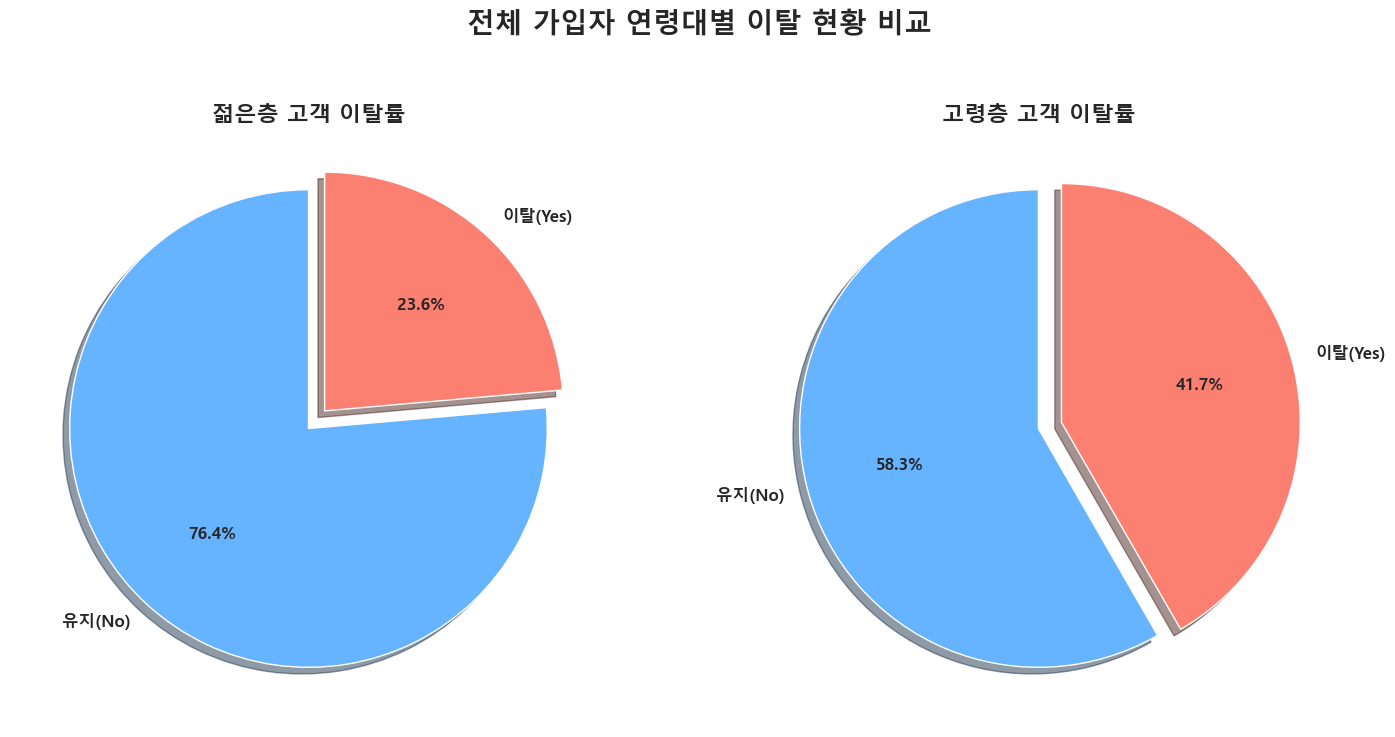

In [23]:
# 1. 데이터 준비
# 젊은층(0)과 고령자(1) 데이터 분리 및 이탈 비중 계산
young_churn = df[df['SeniorCitizen'] == 0]['Churn'].value_counts()
senior_churn = df[df['SeniorCitizen'] == 1]['Churn'].value_counts()

# 2. 1행 2열 원형 그래프 생성
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
colors = ['#66b3ff', '#fb8072'] # 유지(No): 파랑, 이탈(Yes): 주황
explode = (0, 0.1) # 이탈 부분을 살짝 강조

# --- [왼쪽] 젊은층 이탈률 ---
axes[0].pie(young_churn, labels=['유지(No)', '이탈(Yes)'], autopct='%.1f%%', 
            startangle=90, colors=colors, explode=explode, shadow=True,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('젊은층 고객 이탈률', fontsize=16, fontweight='bold')

# --- [오른쪽] 고령층 이탈률 ---
axes[1].pie(senior_churn, labels=['유지(No)', '이탈(Yes)'], autopct='%.1f%%', 
            startangle=90, colors=colors, explode=explode, shadow=True,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('고령층 고객 이탈률', fontsize=16, fontweight='bold')

# 전체 제목
plt.suptitle('전체 가입자 연령대별 이탈 현황 비교', fontsize=20, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

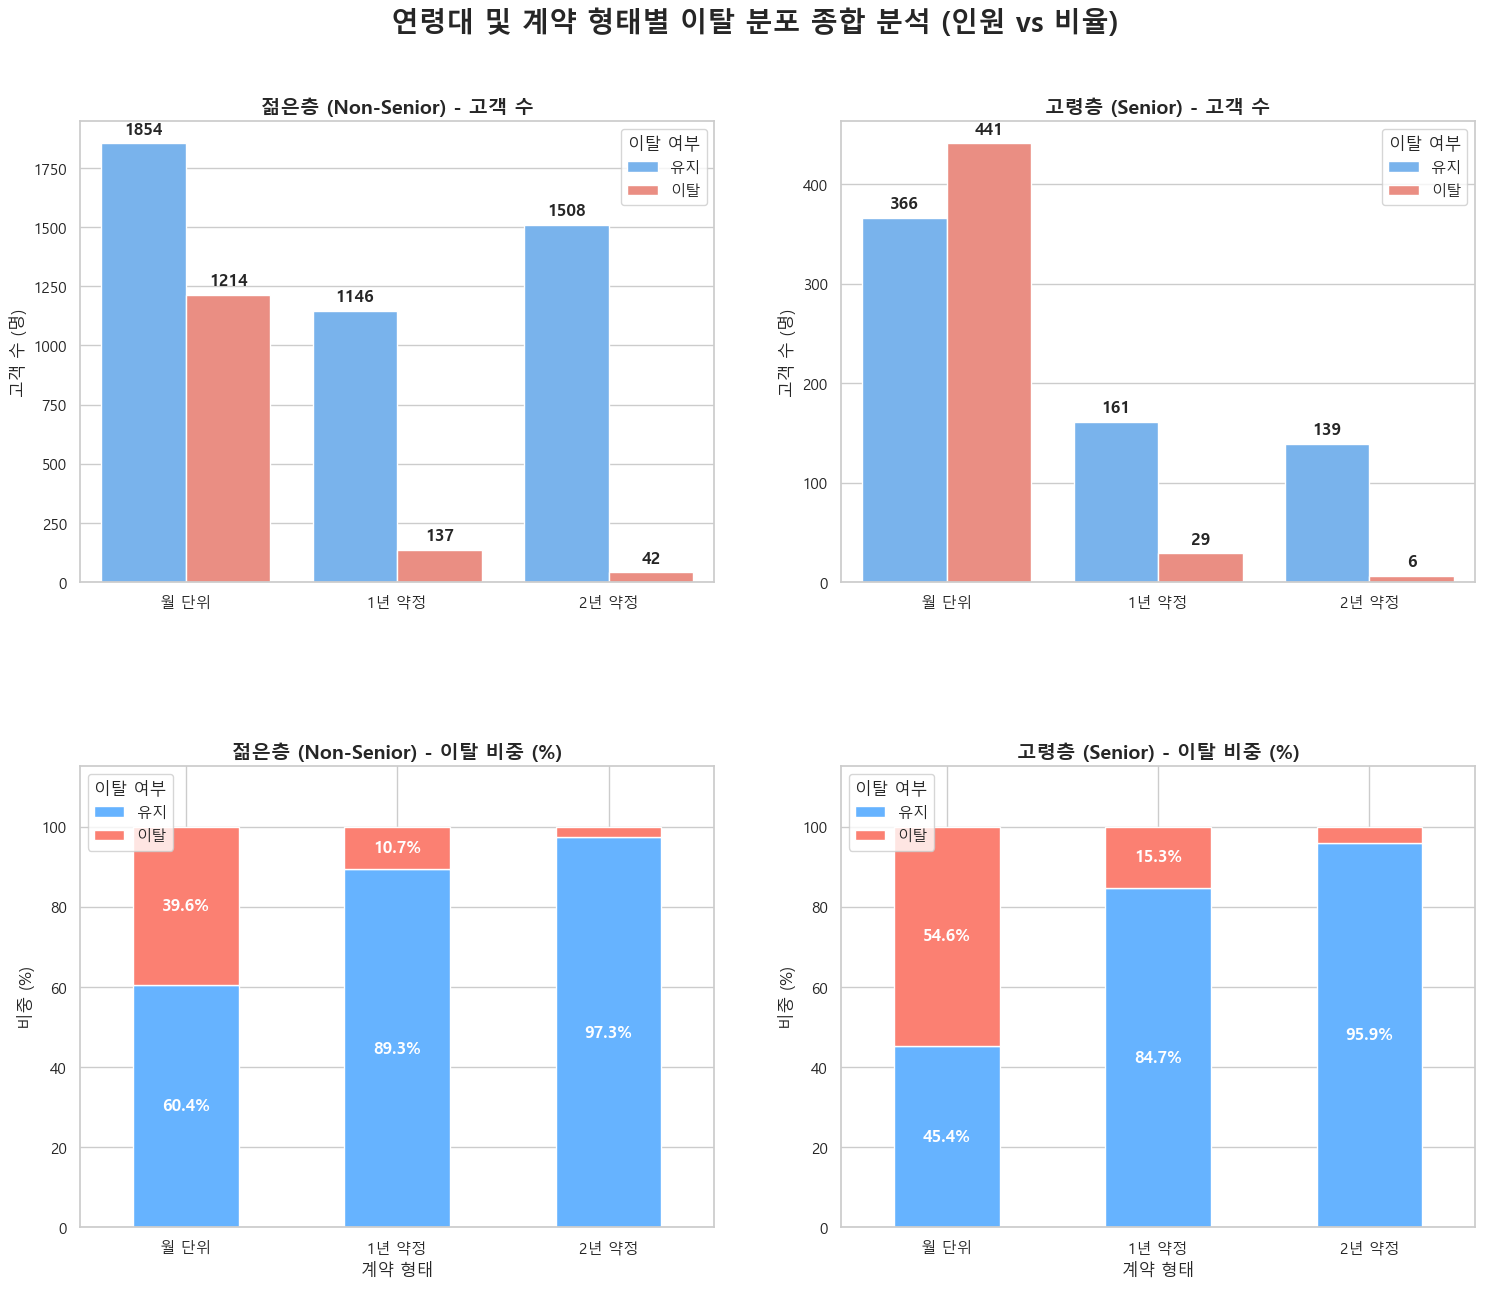

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 2. 2행 2열 캔버스 설정
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.2, top=0.9)

# 데이터 정렬 순서 정의
contract_order = ['Month-to-month', 'One year', 'Two year']
contract_labels = ['월 단위', '1년 약정', '2년 약정']

# --- [상단: Row 0] 고객 수 (Count) 그래프 ---
for i, senior_val in enumerate([0, 1]):
    ax = axes[0, i]
    subset = df[df['SeniorCitizen'] == senior_val]
    
    sns.countplot(data=subset, x='Contract', hue='Churn', ax=ax,
                  palette=['#66b3ff', '#fb8072'], 
                  hue_order=['No', 'Yes'], order=contract_order)
    
    title = '젊은층 (Non-Senior)' if senior_val == 0 else '고령층 (Senior)'
    ax.set_title(f'{title} - 고객 수', fontsize=14, fontweight='bold')
    ax.set_xticklabels(contract_labels)
    ax.set_xlabel('')
    ax.set_ylabel('고객 수 (명)')
    ax.legend(title='이탈 여부', labels=['유지', '이탈'])
    
    # 숫자 표시
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2., height),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

# --- [하단: Row 1] 이탈 비율 (Percentage) 그래프 ---
for i, senior_val in enumerate([0, 1]):
    ax = axes[1, i]
    subset = df[df['SeniorCitizen'] == senior_val]
    
    # 계약별 이탈 비율 계산
    prop_df = subset.groupby('Contract')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
    prop_df = prop_df.reindex(contract_order)
    
    prop_df.plot(kind='bar', stacked=True, ax=ax, color=['#66b3ff', '#fb8072'], rot=0)
    
    title = '젊은층 (Non-Senior)' if senior_val == 0 else '고령층 (Senior)'
    ax.set_title(f'{title} - 이탈 비중 (%)', fontsize=14, fontweight='bold')
    ax.set_xticklabels(contract_labels)
    ax.set_xlabel('계약 형태')
    ax.set_ylabel('비중 (%)')
    ax.set_ylim(0, 115) # 텍스트 공간 확보
    ax.legend(title='이탈 여부', labels=['유지', '이탈'])
    
    # 비율 표시
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if height > 5: # 5% 이상일 때만 표시
            ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2),
                        ha='center', va='center', color='white', fontweight='bold')

# 전체 제목
fig.suptitle('연령대 및 계약 형태별 이탈 분포 종합 분석 (인원 vs 비율)', fontsize=20, fontweight='bold')

plt.show()

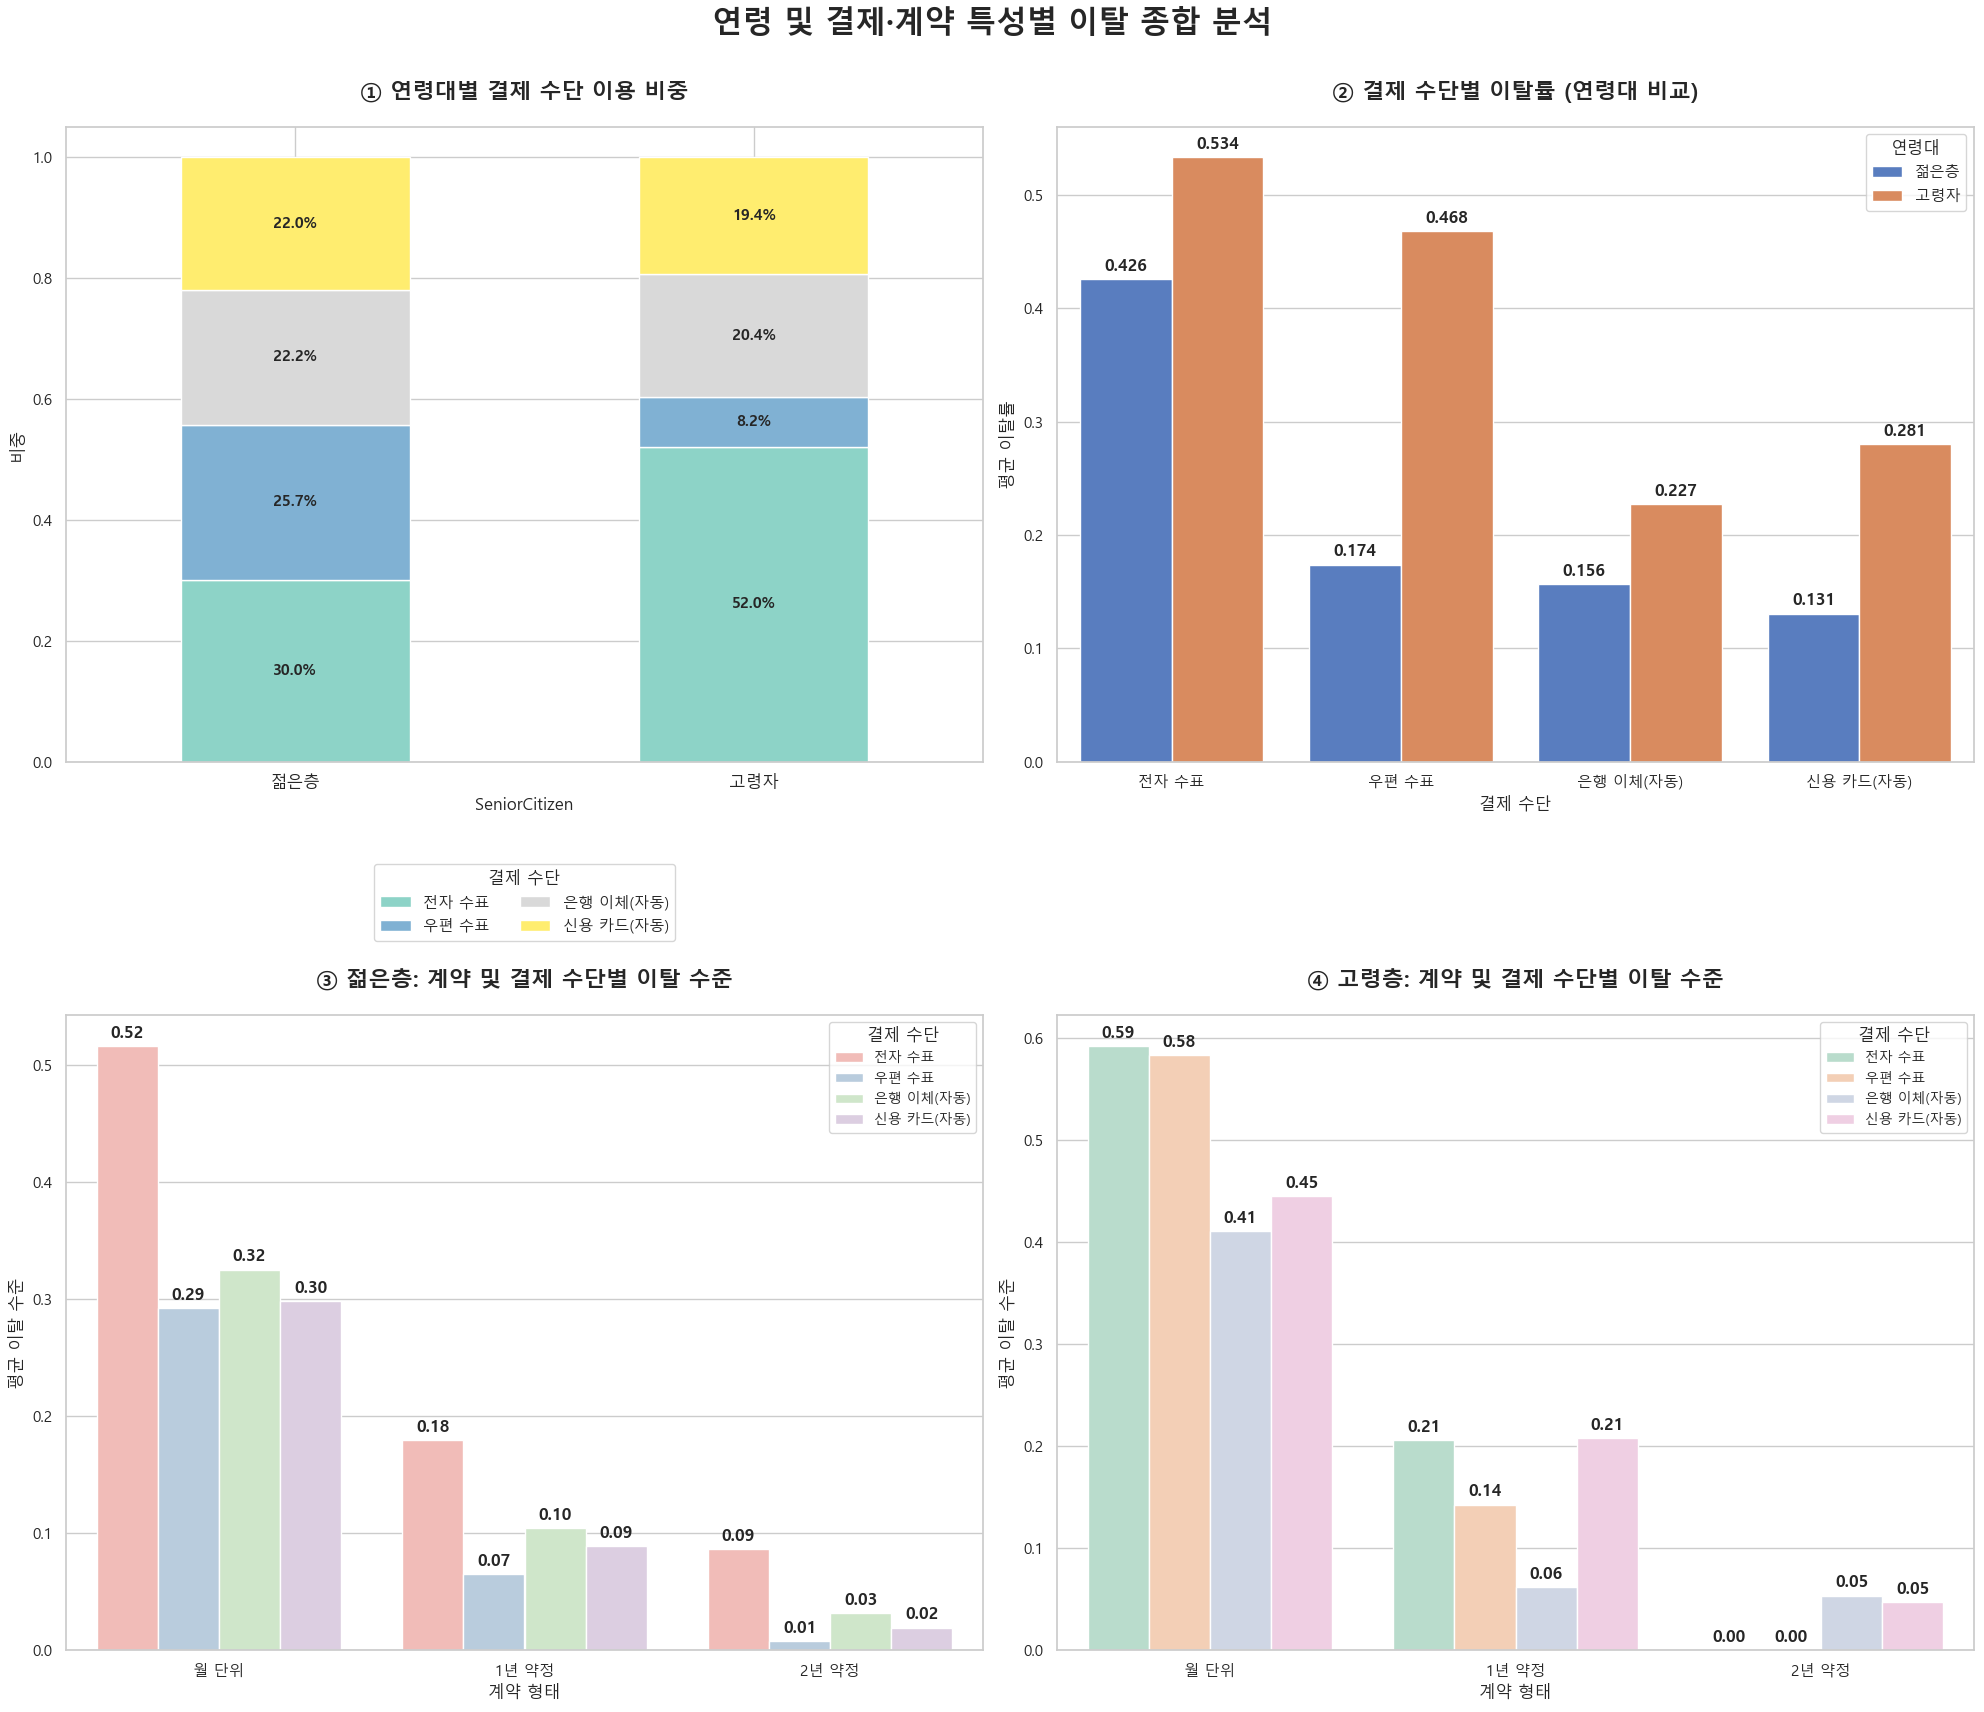

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. 한글 폰트 및 스타일 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 복사 및 결제 수단 한글화
df_kor = df.copy()
payment_kor = {
    'Electronic check': '전자 수표',
    'Mailed check': '우편 수표',
    'Bank transfer (automatic)': '은행 이체(자동)',
    'Credit card (automatic)': '신용 카드(자동)'
}
df_kor['PaymentMethod_Kor'] = df_kor['PaymentMethod'].map(payment_kor)

# 2. 2행 2열 캔버스 생성 (높이를 충분히 확보)
fig, axes = plt.subplots(2, 2, figsize=(20, 18))

# 공통 설정
payment_order = ['전자 수표', '우편 수표', '은행 이체(자동)', '신용 카드(자동)']
contract_labels = ['월 단위', '1년 약정', '2년 약정']

# --- [1행 1열] 연령대별 결제 수단 이용 비중 ---
senior_payment = pd.crosstab(df_kor['SeniorCitizen'], df_kor['PaymentMethod_Kor'])
senior_payment_prop = senior_payment.div(senior_payment.sum(1).astype(float), axis=0)
senior_payment_prop = senior_payment_prop.reindex(columns=payment_order)

senior_payment_prop.plot(kind='bar', stacked=True, ax=axes[0, 0], colormap='Set3', rot=0)

for n, x in enumerate([*senior_payment_prop.index.values]):
    cumulative_h = 0
    for col in payment_order:
        prop = senior_payment_prop.loc[x, col]
        if prop > 0.05:
            axes[0, 0].text(x=n, y=cumulative_h + (prop/2), s=f'{prop*100:.1f}%', 
                            ha="center", va="center", fontweight="bold", fontsize=11)
        cumulative_h += prop

axes[0, 0].set_title('① 연령대별 결제 수단 이용 비중', fontsize=16, fontweight='bold', pad=20)
axes[0, 0].set_xticklabels(['젊은층', '고령자'], fontsize=12)
axes[0, 0].set_ylabel('비중')
# 범례 위치를 그래프 아래로 내리고 간격을 조절하여 3번 그래프와 겹침 방지
axes[0, 0].legend(title='결제 수단', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)


# --- [1행 2열] 결제 수단별 이탈률 (연령대 비교) ---
sns.barplot(x='PaymentMethod_Kor', y='Churn_Numeric', hue='SeniorCitizen', data=df_kor, 
            ax=axes[0, 1], palette='muted', ci=None, order=payment_order)

for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%.3f', padding=3, fontweight='bold')

axes[0, 1].set_title('② 결제 수단별 이탈률 (연령대 비교)', fontsize=16, fontweight='bold', pad=20)
axes[0, 1].set_xlabel('결제 수단')
axes[0, 1].set_ylabel('평균 이탈률')
axes[0, 1].legend(title='연령대', labels=['젊은층', '고령자'], loc='upper right')


# --- [2행 1열] 젊은층: 계약 및 결제수단별 이탈 수준 ---
young_df = df_kor[df_kor['SeniorCitizen'] == 0]
sns.barplot(data=young_df, x='Contract', y='Churn_Numeric', hue='PaymentMethod_Kor', 
            palette='Pastel1', ci=None, ax=axes[1, 0], 
            order=['Month-to-month', 'One year', 'Two year'], hue_order=payment_order)

for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fmt='%.2f', padding=3, fontweight='bold')

axes[1, 0].set_title('③ 젊은층: 계약 및 결제 수단별 이탈 수준', fontsize=16, fontweight='bold', pad=20)
axes[1, 0].set_xticklabels(contract_labels)
axes[1, 0].set_xlabel('계약 형태')
axes[1, 0].set_ylabel('평균 이탈 수준')
axes[1, 0].legend(title='결제 수단', loc='upper right', fontsize=10)


# --- [2행 2열] 고령층: 계약 및 결제수단별 이탈 수준 ---
senior_df = df_kor[df_kor['SeniorCitizen'] == 1]
sns.barplot(data=senior_df, x='Contract', y='Churn_Numeric', hue='PaymentMethod_Kor', 
            palette='Pastel2', ci=None, ax=axes[1, 1], 
            order=['Month-to-month', 'One year', 'Two year'], hue_order=payment_order)

for container in axes[1, 1].containers:
    axes[1, 1].bar_label(container, fmt='%.2f', padding=3, fontweight='bold')

axes[1, 1].set_title('④ 고령층: 계약 및 결제 수단별 이탈 수준', fontsize=16, fontweight='bold', pad=20)
axes[1, 1].set_xticklabels(contract_labels)
axes[1, 1].set_xlabel('계약 형태')
axes[1, 1].set_ylabel('평균 이탈 수준')
axes[1, 1].legend(title='결제 수단', loc='upper right', fontsize=10)

# 3. 레이아웃 최종 조정
# hspace를 0.4 정도로 주고 rect로 전체 제목 공간 확보
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.4) 

fig.suptitle('연령 및 결제·계약 특성별 이탈 종합 분석', fontsize=22, fontweight='bold')

plt.show()

* 고령자가 상대적으로 더 이탈이 많은데, 다음과 같은 이유가 있다.
* 월 단위 계약자가 많다. -> 월 단위 계약은 장기 계약보다 기본 요금이 비싸기 때문에, 부담 임계치를 넘으면 쉽게 이탈함.
* 거래 방식 중, 전자수표의 비율이 52%로 높다.

# ④ 부가서비스

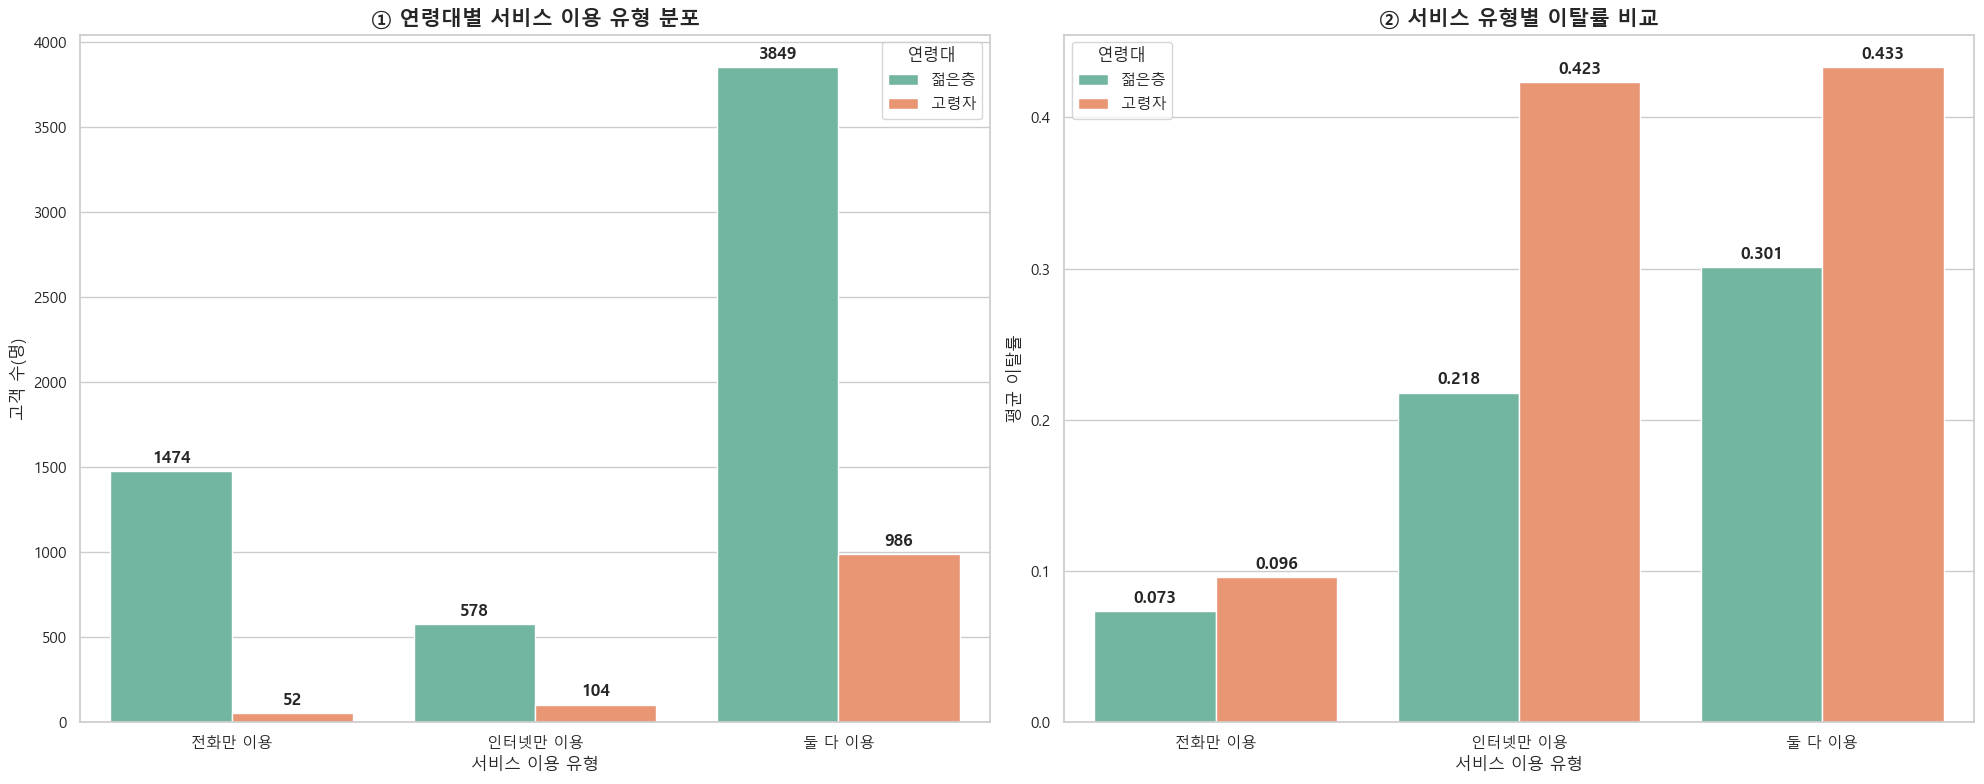

--- 서비스 유형 및 연령대별 이탈률 상세 ---
연령대               고령자       젊은층
ServiceType                    
둘 다 이용       0.433063  0.301117
인터넷만 이용      0.423077  0.217993
전화만 이용       0.096154  0.073270


In [26]:
# 1. 서비스 이용 유형 분류 함수 정의
def classify_service(row):
    has_phone = (row['PhoneService'] == 'Yes')
    has_internet = (row['InternetService'] != 'No')
    
    if has_phone and has_internet:
        return '둘 다 이용'
    elif has_phone:
        return '전화만 이용'
    elif has_internet:
        return '인터넷만 이용'
    else:
        return '둘 다 미이용'

# 2. 데이터 가공
df_combo = df.copy()
df_combo['ServiceType'] = df_combo.apply(classify_service, axis=1)
df_combo['연령대'] = df_combo['SeniorCitizen'].replace({0: '젊은층', 1: '고령자'})
# 이탈 여부를 수치화 (이탈률 계산용)
df_combo['Churn_Numeric'] = df_combo['Churn'].map({'Yes': 1, 'No': 0})

# 3. 1행 2열 캔버스 구성
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- [왼쪽] 연령대별 서비스 이용 유형 분포 (고객 수) ---
ax1 = sns.countplot(data=df_combo, x='ServiceType', hue='연령대', 
                    order=['전화만 이용', '인터넷만 이용', '둘 다 이용'],
                    palette='Set2', ax=axes[0])

for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', padding=3, fontweight='bold')

axes[0].set_title('① 연령대별 서비스 이용 유형 분포', fontsize=15, fontweight='bold')
axes[0].set_xlabel('서비스 이용 유형')
axes[0].set_ylabel('고객 수(명)')

# --- [오른쪽] 서비스 이용 유형별 이탈률 (평균값) ---
# 연령대별 차이를 보기 위해 hue에 '연령대' 적용
ax2 = sns.barplot(data=df_combo, x='ServiceType', y='Churn_Numeric', hue='연령대',
                  order=['전화만 이용', '인터넷만 이용', '둘 다 이용'],
                  palette='Set2', errorbar=None, ax=axes[1])

# 이탈률 수치 표시
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f', padding=3, fontweight='bold')

axes[1].set_title('② 서비스 유형별 이탈률 비교', fontsize=15, fontweight='bold')
axes[1].set_xlabel('서비스 이용 유형')
axes[1].set_ylabel('평균 이탈률')

plt.tight_layout()
plt.show()

# 4. 수치 요약 출력
summary = df_combo.groupby(['ServiceType', '연령대'])['Churn_Numeric'].mean().unstack()
print("--- 서비스 유형 및 연령대별 이탈률 상세 ---")
print(summary)

<Figure size 1400x800 with 0 Axes>

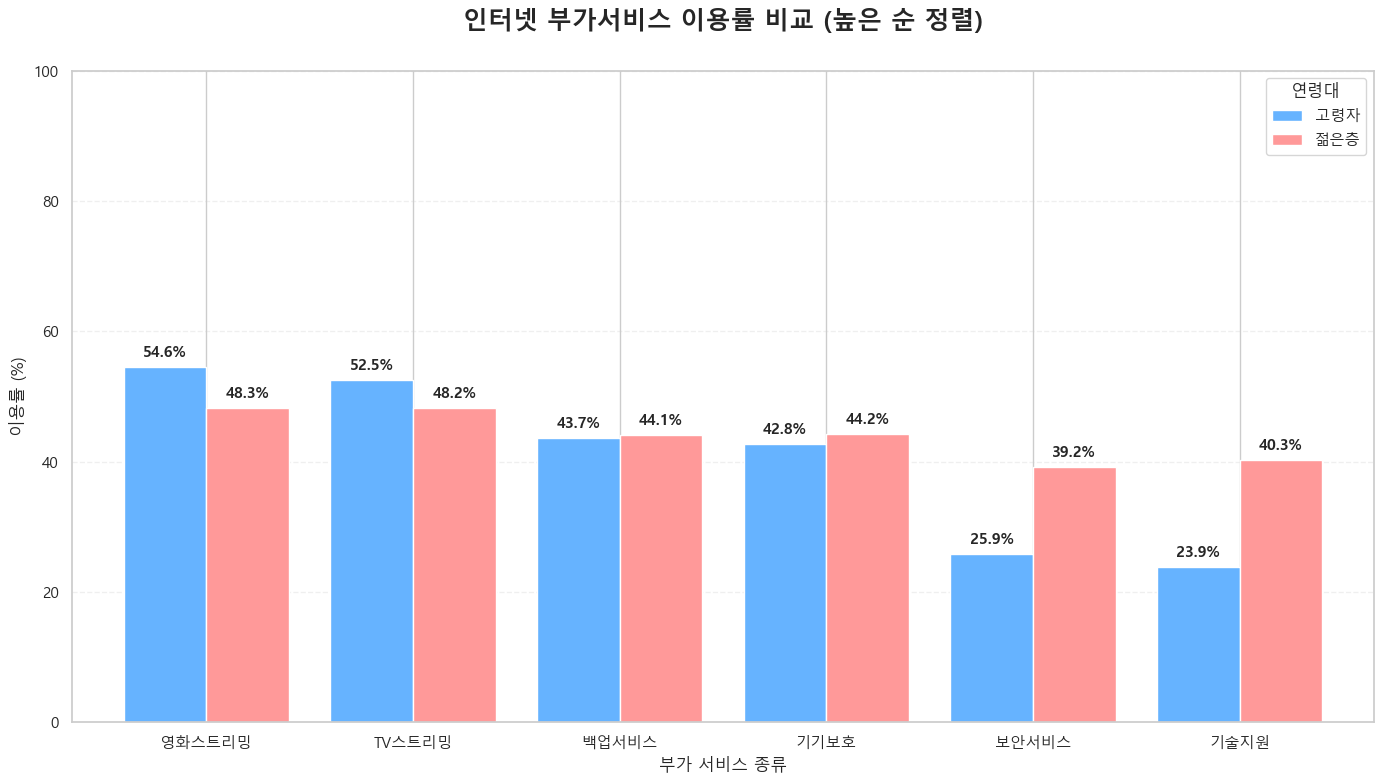

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. 데이터 준비 및 필터링
df_plot = df.copy()
df_plot['연령대'] = df_plot['SeniorCitizen'].replace({0: '젊은층', 1: '고령자'})

# 인터넷 서비스 이용자만 추출
it_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
internet_users = df_plot[df_plot['InternetService'] != 'No']

# 연령대별 서비스 이용률 계산
it_usage = internet_users.groupby('연령대')[it_services].apply(lambda x: (x == 'Yes').mean() * 100).T

# --- 정렬 로직 추가 ---
# 전체 평균 이용률을 계산하여 내림차순 정렬 기준 생성
it_usage['Total_Avg'] = it_usage.mean(axis=1)
it_usage = it_usage.sort_values(by='Total_Avg', ascending=False)
it_usage = it_usage.drop(columns='Total_Avg') # 정렬 후 임시 컬럼 삭제

# 한글 매핑 (정렬된 인덱스 순서에 맞춰서 다시 매핑)
kor_map = {
    'OnlineSecurity': '보안서비스', 'OnlineBackup': '백업서비스', 
    'DeviceProtection': '기기보호', 'TechSupport': '기술지원', 
    'StreamingTV': 'TV스트리밍', 'StreamingMovies': '영화스트리밍'
}
sorted_kor_labels = [kor_map[idx] for idx in it_usage.index]

# 2. 시각화
plt.figure(figsize=(14, 8))

# 막대 그래프 그리기 (컬러 및 범례 순서 고정)
ax = it_usage.plot(kind='bar', figsize=(14, 8), color=['#66b3ff', '#ff9999'], width=0.8)

# 3. 그래프 꾸미기
plt.title('인터넷 부가서비스 이용률 비교 (높은 순 정렬)', fontsize=18, fontweight='bold', pad=30)
plt.ylabel('이용률 (%)', fontsize=12)
plt.xlabel('부가 서비스 종류', fontsize=12)
plt.xticks(range(len(sorted_kor_labels)), sorted_kor_labels, rotation=0, fontsize=11)
plt.ylim(0, 100)
plt.legend(title='연령대', labels=['고령자', '젊은층'], loc='upper right', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 막대 위에 수치(%) 표시
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

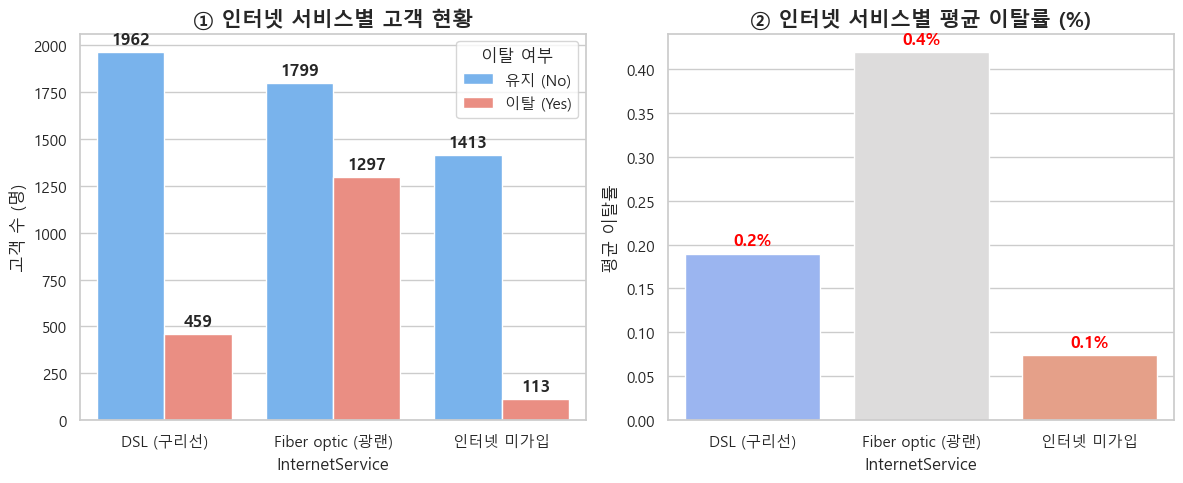

In [28]:
# 1. 시각화할 라벨 정의
labels = ['DSL (구리선)', 'Fiber optic (광랜)', '인터넷 미가입']

# 2. 캔버스 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- [왼쪽] 인터넷 서비스 유형별 고객 수 분포 ---
sns.countplot(data=df, x='InternetService', hue='Churn', 
              palette=['#66b3ff', '#fb8072'], hue_order=['No', 'Yes'], 
              order=['DSL', 'Fiber optic', 'No'], ax=axes[0])

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', padding=3, fontweight='bold')

axes[0].set_title('① 인터넷 서비스별 고객 현황', fontsize=15, fontweight='bold')
axes[0].set(xticks=range(len(labels)), xticklabels=labels)
axes[0].set_ylabel('고객 수 (명)')
axes[0].legend(title='이탈 여부', labels=['유지 (No)', '이탈 (Yes)'])

# --- [오른쪽] 인터넷 서비스 유형별 이탈률 (%) ---
# 이탈률 계산 (Churn_Numeric이 0, 1이라고 가정)
internet_churn_rate = df.groupby('InternetService')['Churn_Numeric'].mean().reset_index()

sns.barplot(data=internet_churn_rate, x='InternetService', y='Churn_Numeric', 
            order=['DSL', 'Fiber optic', 'No'], hue='InternetService', palette='coolwarm', ax=axes[1])

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', padding=3, fontweight='bold', color='red')

axes[1].set_title('② 인터넷 서비스별 평균 이탈률 (%)', fontsize=15, fontweight='bold')
axes[1].set(xticks=range(len(labels)), xticklabels=labels)
axes[1].set_ylabel('평균 이탈률')

plt.tight_layout()
plt.show()

* DSL과 나머지보다 fiber optic이 압도적으로 이탈률이 높다. (DSL의 2배 보다 큰 42%를 차지함)
*  광랜의 높은 요금이 고객 만족도를 저해하고 있거나, 안정성 이슈가 있을 수 있음. -> 모델링 시 월간요금이 높은 사용자 중, 광랜 이용자 들을 변수로 선정

In [29]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Numeric,ServiceCount
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,2
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,No,0,4
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,4
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,4
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,2


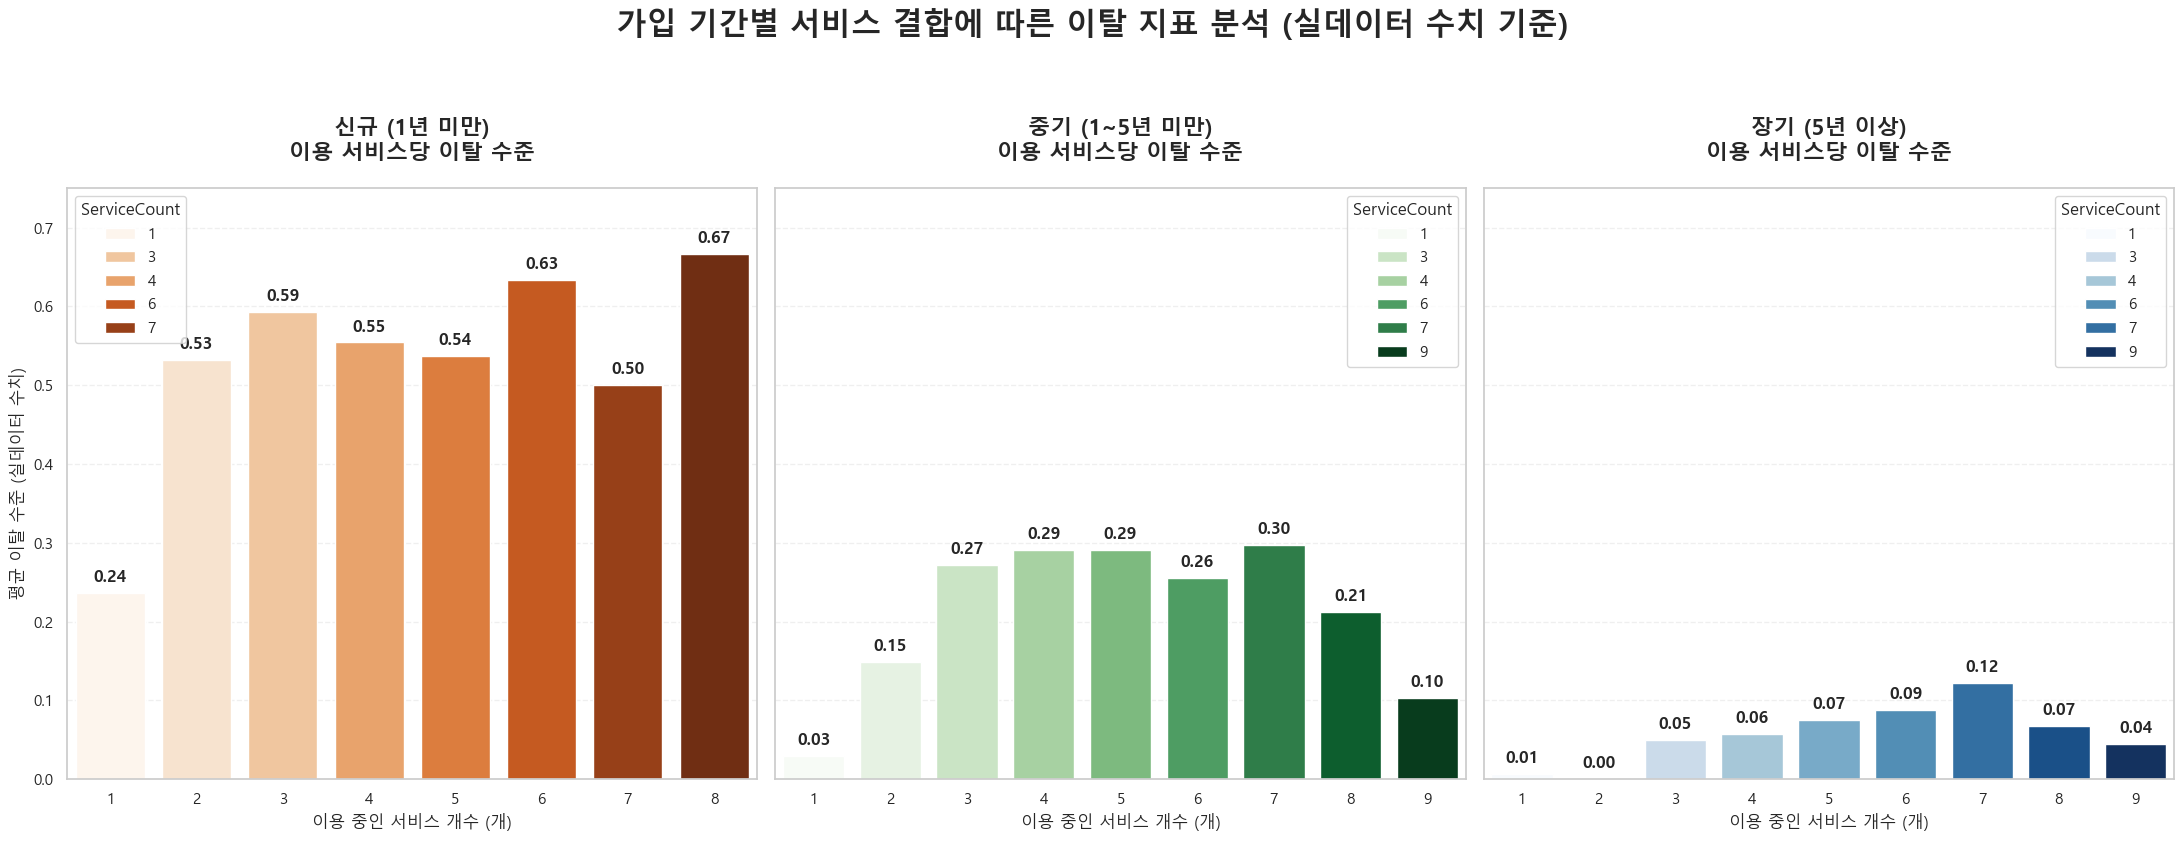

In [30]:
# 1. 데이터 분류 로직
df_tenure = df.copy()
def classify_tenure_3(t):
    if t < 12: return '신규 (1년 미만)'
    elif 12 <= t < 60: return '중기 (1~5년 미만)'
    else: return '장기 (5년 이상)'

df_tenure['가입기간_그룹'] = df_tenure['tenure'].apply(classify_tenure_3)
group_order = ['신규 (1년 미만)', '중기 (1~5년 미만)', '장기 (5년 이상)']

# 2. 1행 3열 캔버스 생성 (Y축 공유를 통해 상대적 크기 비교 유지)
fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)

# 색상 테마: 신규(Orange), 중기(Green), 장기(Blue)
palettes = ['Oranges', 'Greens', 'Blues']

for i, group in enumerate(group_order):
    # 해당 그룹 데이터 추출
    subset = df_tenure[df_tenure['가입기간_그룹'] == group]
    
    # 그래프 그리기 (실제 데이터 Churn_Numeric 0~1 범위를 그대로 사용)
    sns.barplot(data=subset, x='ServiceCount', y='Churn_Numeric', hue='ServiceCount',
                palette=palettes[i], errorbar=None, ax=axes[i])
    
    # 막대 위에 실제 데이터 수치 표시 (소수점 둘째 자리까지)
    for container in axes[i].containers:
        # fmt='%.2f'를 사용하여 0.457... 을 0.46 등으로 표시
        axes[i].bar_label(container, fmt='%.2f', padding=5, fontweight='bold', fontsize=12)
    
    axes[i].set_title(f'{group}\n이용 서비스당 이탈 수준', fontsize=16, fontweight='bold', pad=20)
    axes[i].set_xlabel('이용 중인 서비스 개수 (개)', fontsize=12)
    
    if i == 0:
        axes[i].set_ylabel('평균 이탈 수준 (실데이터 수치)', fontsize=12)
    else:
        axes[i].set_ylabel('')
        
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)
    # Y축 범위는 실제 데이터 범위인 0~1 사이로 최적화
    axes[i].set_ylim(0, 0.75) 

# 전체 제목
plt.suptitle('가입 기간별 서비스 결합에 따른 이탈 지표 분석 (실데이터 수치 기준)', fontsize=22, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

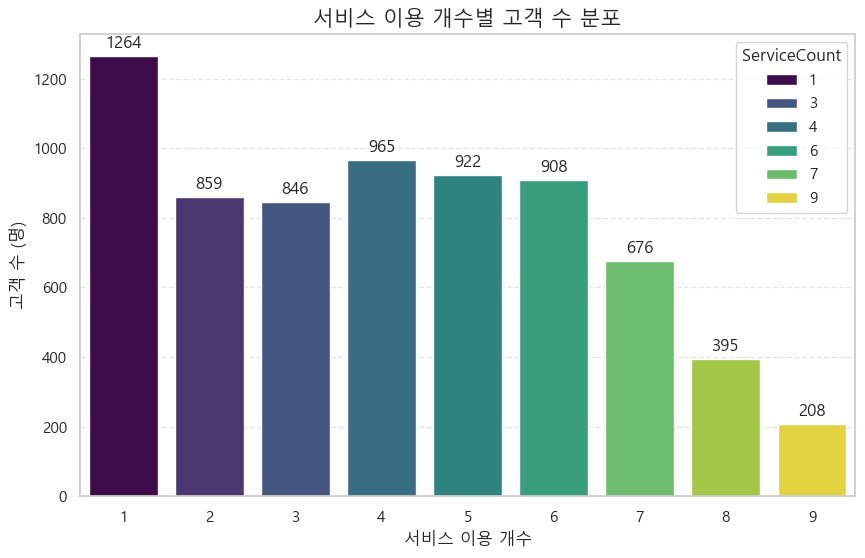

--- 서비스 개수별 비중 ---
ServiceCount
1    17.946898
2    12.196507
3    12.011927
4    13.701548
5    13.091012
6    12.892233
7     9.598183
8     5.608406
9     2.953287
Name: proportion, dtype: float64


In [31]:
# 서비스 개수별 가입자 수 집계
service_counts = df['ServiceCount'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='ServiceCount', data=df, palette='viridis', hue='ServiceCount')

# 막대 위에 가입자 수 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.title('서비스 이용 개수별 고객 수 분포', fontsize=15)
plt.xlabel('서비스 이용 개수')
plt.ylabel('고객 수 (명)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 비율로도 확인
print("--- 서비스 개수별 비중 ---")
print(df['ServiceCount'].value_counts(normalize=True).sort_index() * 100)

* 1년 미만의 신규 고객은 이용중인 서비스의 개수와 이탈율의 상관 관계가 없음
* 중장기 고객은 서비스 개수가 7개가 되는 지점에서 이탈이 늘어나지만 7개를 초과하는 지점에서는 이탈률이 소폭 낮아지는 경향을 보임

# ⑤ 가족형태별

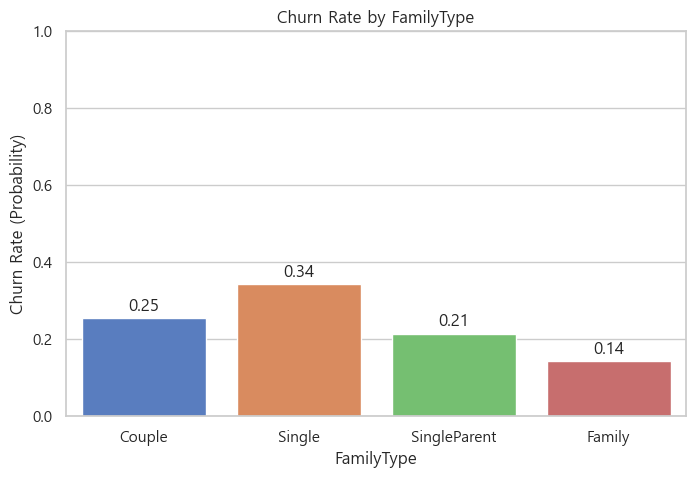

In [32]:
# 가족 결합 여부 (Family Type) 
# Partner(배우자)와 Dependents(부양가족) 정보를 결합
def family_type(row):
    if row['Partner'] == 'Yes' and row['Dependents'] == 'Yes':
        return 'Family'       # 배우자 O, 부양가족 O
    elif row['Partner'] == 'Yes' and row['Dependents'] == 'No':
        return 'Couple'       # 배우자 O, 부양가족 X
    elif row['Partner'] == 'No' and row['Dependents'] == 'Yes':
        return 'SingleParent' # 배우자 X, 부양가족 O
    else:
        return 'Single'       # 1인 가구

df['FamilyType'] = df.apply(family_type, axis=1)

# 카테고리별 '이탈률(Churn Rate)' 시각화
df['Churn_binary'] = df['Churn'].map({'Yes': 1, 'No': 0})

# --- 2. 이탈률 시각화 함수 정의 ---
def plot_churn_rate(column_name):
    plt.figure(figsize=(8, 5))
    
    # barplot은 기본적으로 y값의 '평균'을 계산해줍니다. 
    # 0과 1의 평균 = 이탈률(Probability)이 되므로 아주 유용합니다.
    sns.barplot(x=column_name, y='Churn_binary', data=df, palette='muted', hue=column_name, errorbar=None)
    
    plt.title(f'Churn Rate by {column_name}')
    plt.ylabel('Churn Rate (Probability)')
    plt.ylim(0, 1) # 0% ~ 100% 범위 고정
    
    # 막대 위에 수치 표시 (Optional)
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), textcoords = 'offset points')

# 가족 형태별 이탈률 확인 (보통 1인 가구가 이탈률이 높습니다)
plot_churn_rate('FamilyType')

* 1인 가구 형태에서 이탈률이 가장 크고, 다인 가구 일수록 줄어든다.
* 경제적 이유 : 가족 결합의 경우 인터넷 + TV + 구성원 수 만큼의 회선 등 모두 엮여 있음
* 해지 시 손실 : 결합 할인 등을 받은 고객일 가능성이 높고, 이탈하는 손간 통신비가 급등하게 된다.
* 의사 결정권자 수 차이 : 여러 사람의 요구 사항을 맞춰야 하기 때문에, 적당히 만족하며 유지하는 성향이 강해진다.

# 3. 데이터 전처리 (Preprocessing)
- 불필요한 컬럼 제거 (`customerID`, 시각화용 `Churn_Numeric`)
- 결측치 처리 (이미 위에서 수행함)

In [33]:
# 불필요한 컬럼 제거
#if 'customerID' in df.columns:
#    df = df.drop('customerID', axis=1)

#if 'Churn_Numeric' in df.columns:
#    df = df.drop('Churn_Numeric', axis=1)

# 결측치 재확인
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Churn_Numeric       0
ServiceCount        0
FamilyType          0
Churn_binary        0
dtype: int64


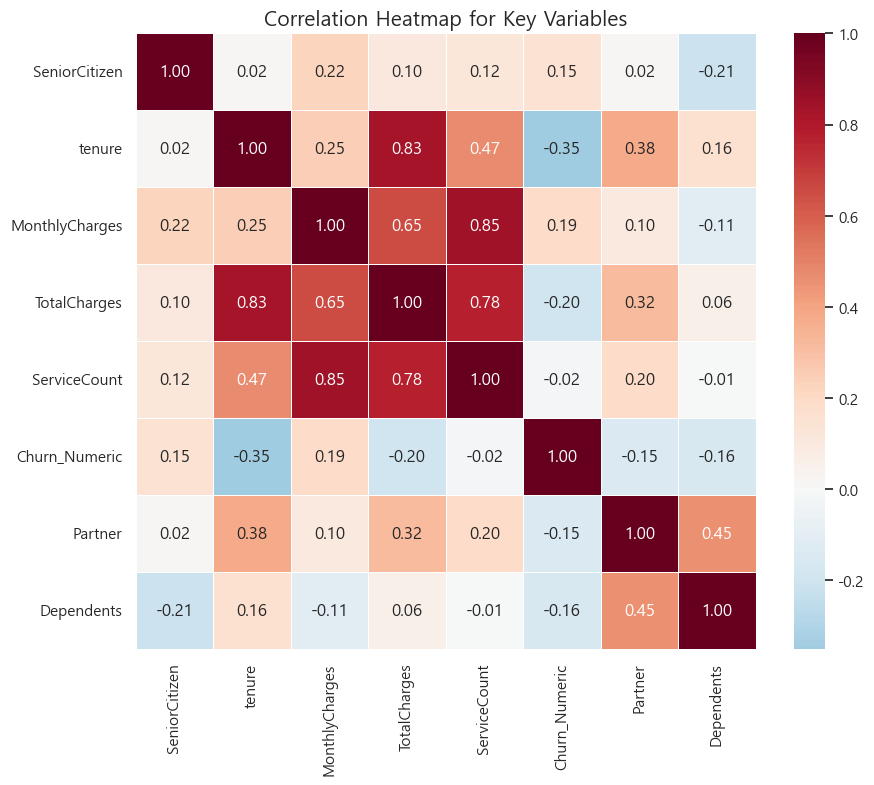

In [34]:
# 1. 상관계수 계산을 위해 수치형 변수들만 선택
# 문자열 데이터를 숫자(0, 1)로 변환
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
# 분석에 사용할 주요 수치형 및 인코딩된 변수 선택
cols_for_corr = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 
                 'ServiceCount', 'Churn_Numeric','Partner','Dependents']

# 2. 상관계수 행렬 생성
corr_matrix = df[cols_for_corr].corr()

# 3. 히트맵 그리기
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # 상단 삼각형 가리기 (중복 제거)

sns.heatmap(corr_matrix, 
            annot=True,      # 수치 표시
            fmt=".2f",      # 소수점 둘째자리까지
            cmap='RdBu_r',  # 붉은색(양의 상관), 푸른색(음의 상관)
            center=0, 
            linewidths=0.5)

plt.title('Correlation Heatmap for Key Variables', fontsize=15)
plt.show()

# 4. 특성 엔지니어링 (Feature Engineering)
- `TenureGroup`: 가입 기간을 그룹화
- `ServicesCount`: 가입한 부가 서비스 수
- `ContractType`: 계약 형태 단순화 (선택 사항)
- Family_Stickiness' :
- 'LongTerm_Complexity_Risk' :
- 'Fiber_Premium_Ratio :

In [35]:
# 1년 단위로 촘촘하게 다시 그룹화
def tenure_group_refined(tenure):
    if tenure <= 12:
        return '1년 이하'
    elif 12<= tenure <= 24:
        return '2년 이하'
    elif 24 <= tenure <= 36:
        return '3년 이하'
    elif 36 <= tenure <= 48:
        return '4년 이하'
    elif 48 <= tenure <= 60:
        return '5년 이하'
    else:
        return '5년 초과'

df['TenureGroup'] = df['tenure'].apply(tenure_group_refined)

# 순서 고정을 위한 리스트 (그래프 그릴 때 사용)
order_list = ['1년 이하', '2년 이하', '3년 이하', '4년 이하', '5년 이하', '5년 초과']

display(df[['tenure', 'TenureGroup']].head())

,tenure,TenureGroup
0,1,1년 이하
1,34,3년 이하
2,2,1년 이하
3,45,4년 이하
4,2,1년 이하


In [36]:
# ---------------------------------------------------------
# 1. 가족 가중치 변수 (Family_Stickiness)
# 가족이 있고 서비스를 많이 쓸수록 '이탈하기 힘든 족쇄'가 강해짐을 의미
# ---------------------------------------------------------
df['IsFamily'] = ((df['Partner'] == 'Yes') | (df['Dependents'] == 'Yes')).astype(int)
df['Family_Stickiness'] = df['IsFamily'] * df['ServiceCount']


# ---------------------------------------------------------
# 2. 장기 고객 역설 변수 (LongTerm_Complexity_Risk)
# 60개월 이상 장기 고객이 서비스 7개 이상일 때 발생하는 이탈 위험을 수치화
# ---------------------------------------------------------
def get_longterm_risk(row):
    if row['tenure'] >= 60 and row['ServiceCount'] >= 7:
        return 1  # 고위험군 (역설적 이탈 구간)
    return 0

df['LongTerm_Complexity_Risk'] = df.apply(get_longterm_risk, axis=1)


# ---------------------------------------------------------
# 3. 광랜 사용자 최적화 변수 (Fiber_Price_Impact)
# 광랜(Fiber optic) 사용자이면서 월 요금이 평균보다 높은 경우의 부담감을 표현
# ---------------------------------------------------------
fiber_avg_bill = df[df['InternetService'] == 'Fiber optic']['MonthlyCharges'].mean()
df['Fiber_Price_Impact'] = df.apply(
    lambda x: x['MonthlyCharges'] if x['InternetService'] == 'Fiber optic' else 0, 
    axis=1
)
# 평균 대비 얼마나 더 내고 있는가? (광랜 사용자만 해당)
df['Fiber_Premium_Ratio'] = df.apply(
    lambda x: x['MonthlyCharges'] / fiber_avg_bill if x['InternetService'] == 'Fiber optic' else 0,
    axis=1
)

print("신규 변수 생성 완료!")
display(df[['Family_Stickiness', 'LongTerm_Complexity_Risk', 'Fiber_Premium_Ratio']].head())

신규 변수 생성 완료!


,Family_Stickiness,LongTerm_Complexity_Risk,Fiber_Premium_Ratio
0,0,0,0.000000
1,0,0,0.000000
2,0,0,0.000000
3,0,0,0.000000
4,0,0,0.772677


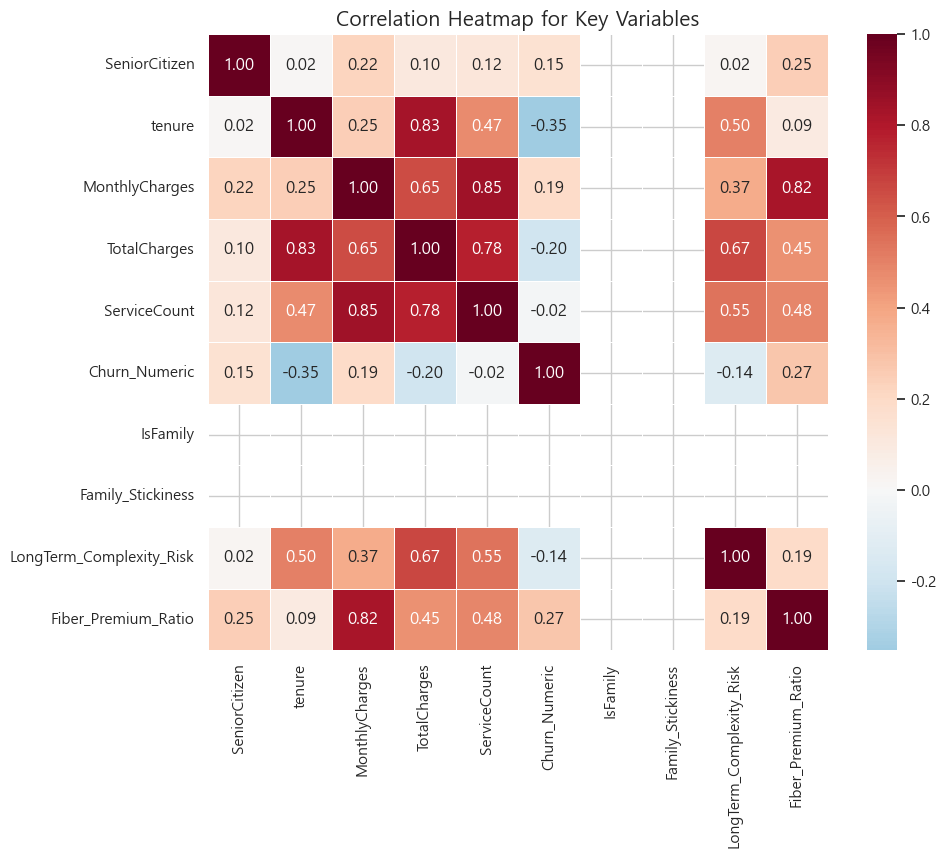

In [37]:
# 분석에 사용할 주요 수치형 및 인코딩된 변수 선택
cols_for_corr = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 
                 'ServiceCount', 'Churn_Numeric', 'IsFamily', 'Family_Stickiness',
                 'LongTerm_Complexity_Risk', 'Fiber_Premium_Ratio']

# 2. 상관계수 행렬 생성
corr_matrix = df[cols_for_corr].corr()

# 3. 히트맵 그리기
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # 상단 삼각형 가리기 (중복 제거)

sns.heatmap(corr_matrix, 
            annot=True,      # 수치 표시
            fmt=".2f",      # 소수점 둘째자리까지
            cmap='RdBu_r',  # 붉은색(양의 상관), 푸른색(음의 상관)
            center=0, 
            linewidths=0.5)

plt.title('Correlation Heatmap for Key Variables', fontsize=15)
plt.show()

In [38]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Churn_Numeric', 'ServiceCount', 'FamilyType', 'Churn_binary',
       'TenureGroup', 'IsFamily', 'Family_Stickiness',
       'LongTerm_Complexity_Risk', 'Fiber_Price_Impact',
       'Fiber_Premium_Ratio'],
      dtype='object')

데이터분할

In [39]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 불필요한 컬럼 및 타겟 설정
drop_cols = ['customerID', 'Churn', 'Churn_Numeric', 'Churn_binary']
X = df.drop(columns=drop_cols)
y = df['Churn_Numeric']

# 카테고리형 변수 자동 처리 (get_dummies)
X = pd.get_dummies(X, drop_first=True)

# 데이터 분할 (학습 8 : 테스트 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"학습 데이터 크기: {X_train.shape}, 테스트 데이터 크기: {X_test.shape}")

학습 데이터 크기: (5634, 44), 테스트 데이터 크기: (1409, 44)


Optuna를 이용한 하이퍼파라미터 최적화 (LightGBM 예시)

In [40]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }
    
    model = LGBMClassifier(**param, random_state=42, verbose=-1)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    return roc_auc_score(y_test, preds)

# 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"최고 AUC 점수: {study.best_value}")
print(f"최적 파라미터: {study.best_params}")

[I 2026-02-11 11:19:22,846] A new study created in memory with name: no-name-90286b78-98e7-47a5-9cbf-5588080f5c6d
Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\COM\miniconda3\envs\DS\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\COM\miniconda3\envs\DS\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\COM\miniconda3\envs\DS\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 4: invalid start byte
[I 2026-02-11 11:19:24,942] Trial 0 finished with value: 0.7055439303521144 and parameters: {'n_estimators': 174, 'learning_rate': 0.24162418782307724, 'max_depth': 4, 'num_leaves': 87, 'subsample': 0.9788154210248347, 'colsample_bytree': 0.8176113386161421}. Best is trial 0 with value: 0.705543

최고 AUC 점수: 0.7217442971918675
최적 파라미터: {'n_estimators': 172, 'learning_rate': 0.0838198702398089, 'max_depth': 5, 'num_leaves': 93, 'subsample': 0.9020530166341525, 'colsample_bytree': 0.6182120495705689}


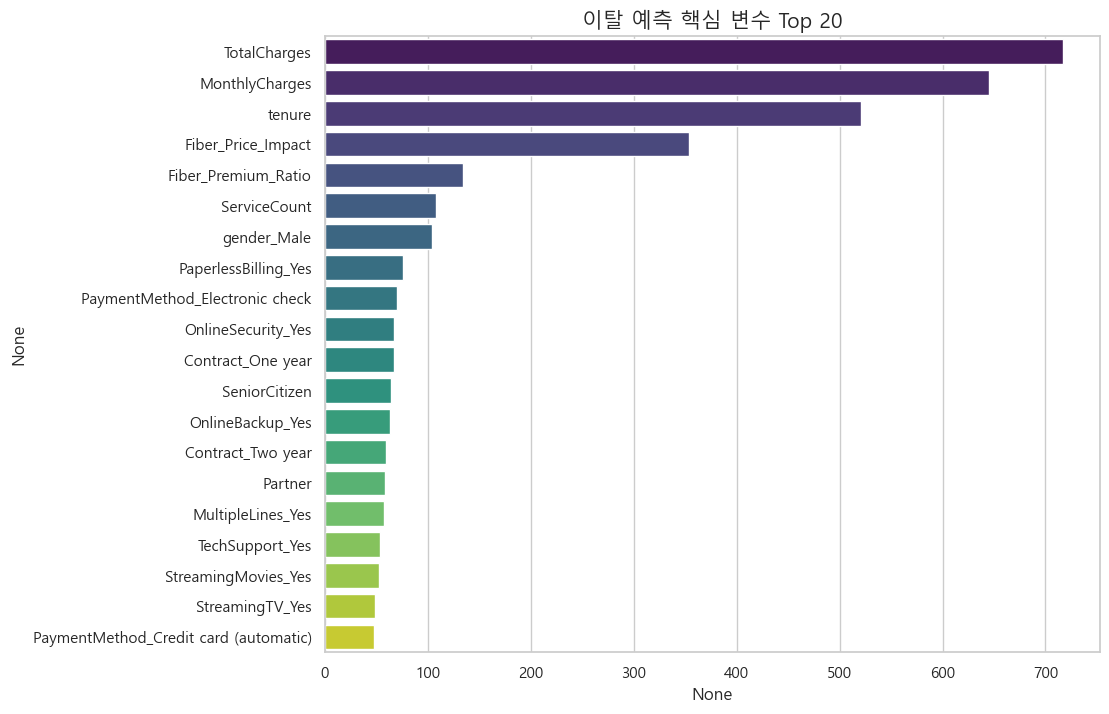

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# 최적 파라미터로 다시 학습된 모델(best_lgbm) 기준
ftr_importances_values = best_lgbm.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
plt.title('이탈 예측 핵심 변수 Top 20', fontsize=15)
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette='viridis')
plt.show()

모델학습 및 앙상블

In [42]:
# 1. 최적화된 LightGBM
best_lgbm = LGBMClassifier(**study.best_params, random_state=42, verbose=-1)

# 2. XGBoost (비슷한 방식으로 최적화했다고 가정하거나 기본값 사용)
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)

# 3. Soft Voting 앙상블 (확률값을 평균내어 결정)
ensemble_model = VotingClassifier(
    estimators=[('lgbm', best_lgbm), ('xgb', xgb_model)],
    voting='soft'
)

ensemble_model.fit(X_train, y_train)

,estimators,"[('lgbm', ...), ('xgb', ...)]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,boosting_type,'gbdt'
,num_leaves,93
,max_depth,5
,learning_rate,0.0838198702398089
,n_estimators,172


모델 비교 평가

In [43]:
models = [best_lgbm, xgb_model, ensemble_model]
model_names = ['LightGBM', 'XGBoost', 'Ensemble']

for name, model in zip(model_names, models):
    if name != 'Ensemble': model.fit(X_train, y_train) # 앙상블은 위에서 fit 완료
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"[{name}] AUC: {auc:.4f} | Accuracy: {acc:.4f}")
    if name == 'Ensemble':
        print("\n--- 최종 앙상블 모델 상세 리포트 ---")
        print(classification_report(y_test, y_pred))

[LightGBM] AUC: 0.8407 | Accuracy: 0.8070
[XGBoost] AUC: 0.8271 | Accuracy: 0.7842
[Ensemble] AUC: 0.8358 | Accuracy: 0.7906

--- 최종 앙상블 모델 상세 리포트 ---
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409

